# RNN

## Погрузка библиотек

In [1]:
import gc
import spacy
import pickle
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score, accuracy_score
from collections import Counter
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Подгрузка функций для обучения

In [3]:
from rnn_functions import ToxicDataset, collate_fn, plot_losses, train_and_validate, get_predictions, find_best_t, show_metrics

## Подготовка данных для обучения

In [4]:
df = pd.read_csv('modified_train.csv',usecols=['comment_text', 'toxicity_b', 'created_date'], parse_dates=['created_date'], date_format='ISO8601')
df = df[df['created_date'] >= '2016-04-01']
df = df.sort_values(by='created_date')[['comment_text', 'toxicity_b']].reset_index(drop=True)

In [ ]:
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

def spacy_tokenizer(text):
    return [tok.text.lower() for tok in nlp(text)]

tokens = []

for doc in tqdm(nlp.pipe(df['comment_text'], batch_size=500, n_process=6)):
    tokens.append([tok.text.lower() for tok in doc])

Сохранение токенов

In [10]:
import pickle

with open("tokens.pkl", "wb") as f:
    pickle.dump(tokens, f)

In [5]:
with open("tokens.pkl", "rb") as f:
    tokens = pickle.load(f)

In [6]:
vocab_size = 40734
specials = ['<pad>', '<unk>']
counter = Counter()

for t in tokens:
    counter.update(t)

most_common = counter.most_common(vocab_size - len(specials))
counter = Counter(dict(most_common))

vocab_obj = Vocab(counter, specials=specials)
vocab_obj.unk_index = vocab_obj.stoi["<unk>"]

In [7]:
numericalized_texts = [torch.tensor([vocab_obj[token] for token in text]) for text in tokens]
labels = torch.tensor(df['toxicity_b'].values, dtype=torch.float32)

In [8]:
X_train, y_train = numericalized_texts[:1428245], labels[:1428245]
X_test, y_test = numericalized_texts[1428245:], labels[1428245:]
X_val, y_val = X_train[1142596:], y_train[1142596:]
X_train, y_train = X_train[:1142596], y_train[:1142596]

In [9]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=vocab_obj["<pad>"])
    return padded, torch.tensor(labels)

In [10]:
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)
test_dataset = ToxicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)
train_loader_test = DataLoader(train_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

## Обучение моделей GRU

Модели GRU будут обучаться только в базовом варианте для демонстрации, так как LSTM модели считаются более мощными.

In [11]:
def f1_metric(preds, targets):
    probs = torch.sigmoid(preds)
    preds_cls = (probs > 0.5).int().cpu().numpy()
    targets_cls = targets.int().cpu().numpy()
    return f1_score(targets_cls, preds_cls, average="binary", zero_division=0)

**GRU 1 Layer**

In [12]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=40734,
        embedding_size=512,
        hidden_size=256,
        num_classes=2,
        num_layers=1,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_size)
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        last_hidden = hidden[-1]
        return self.linear(last_hidden).squeeze(1)

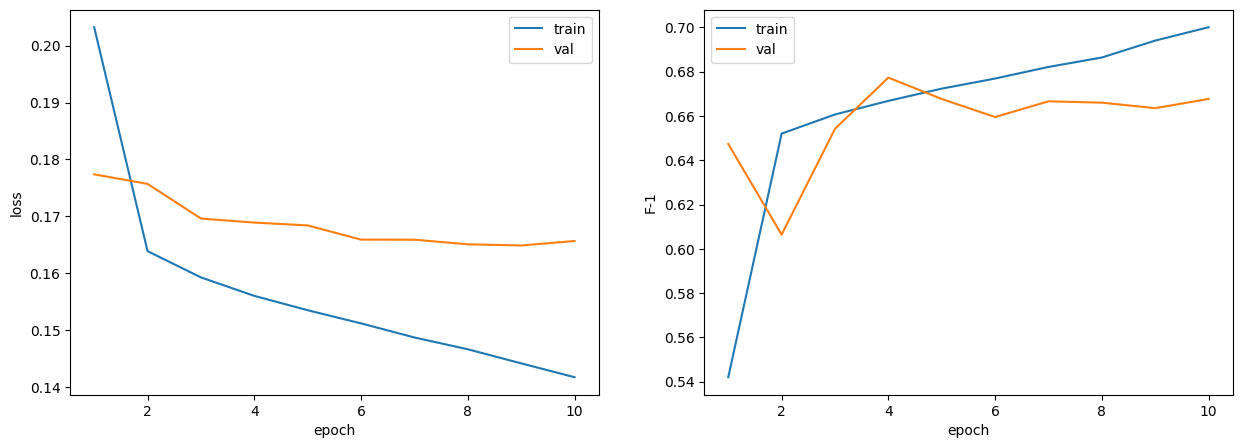

Best Validation Loss: 0.1649 (model saved to GRU1_best.pth)


In [13]:
model = GRUClassifier().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='GRU1_best.pth'
)

In [14]:
model.load_state_dict(torch.load('GRU1_best.pth'))

<All keys matched successfully>

GRU1 Classifier

Precision		Recall			F1

Train: 0.83		Train: 0.63		Train: 0.72
Val: 0.78		Val: 0.59		Val: 0.67
Test: 0.79		Test: 0.59		Test: 0.68


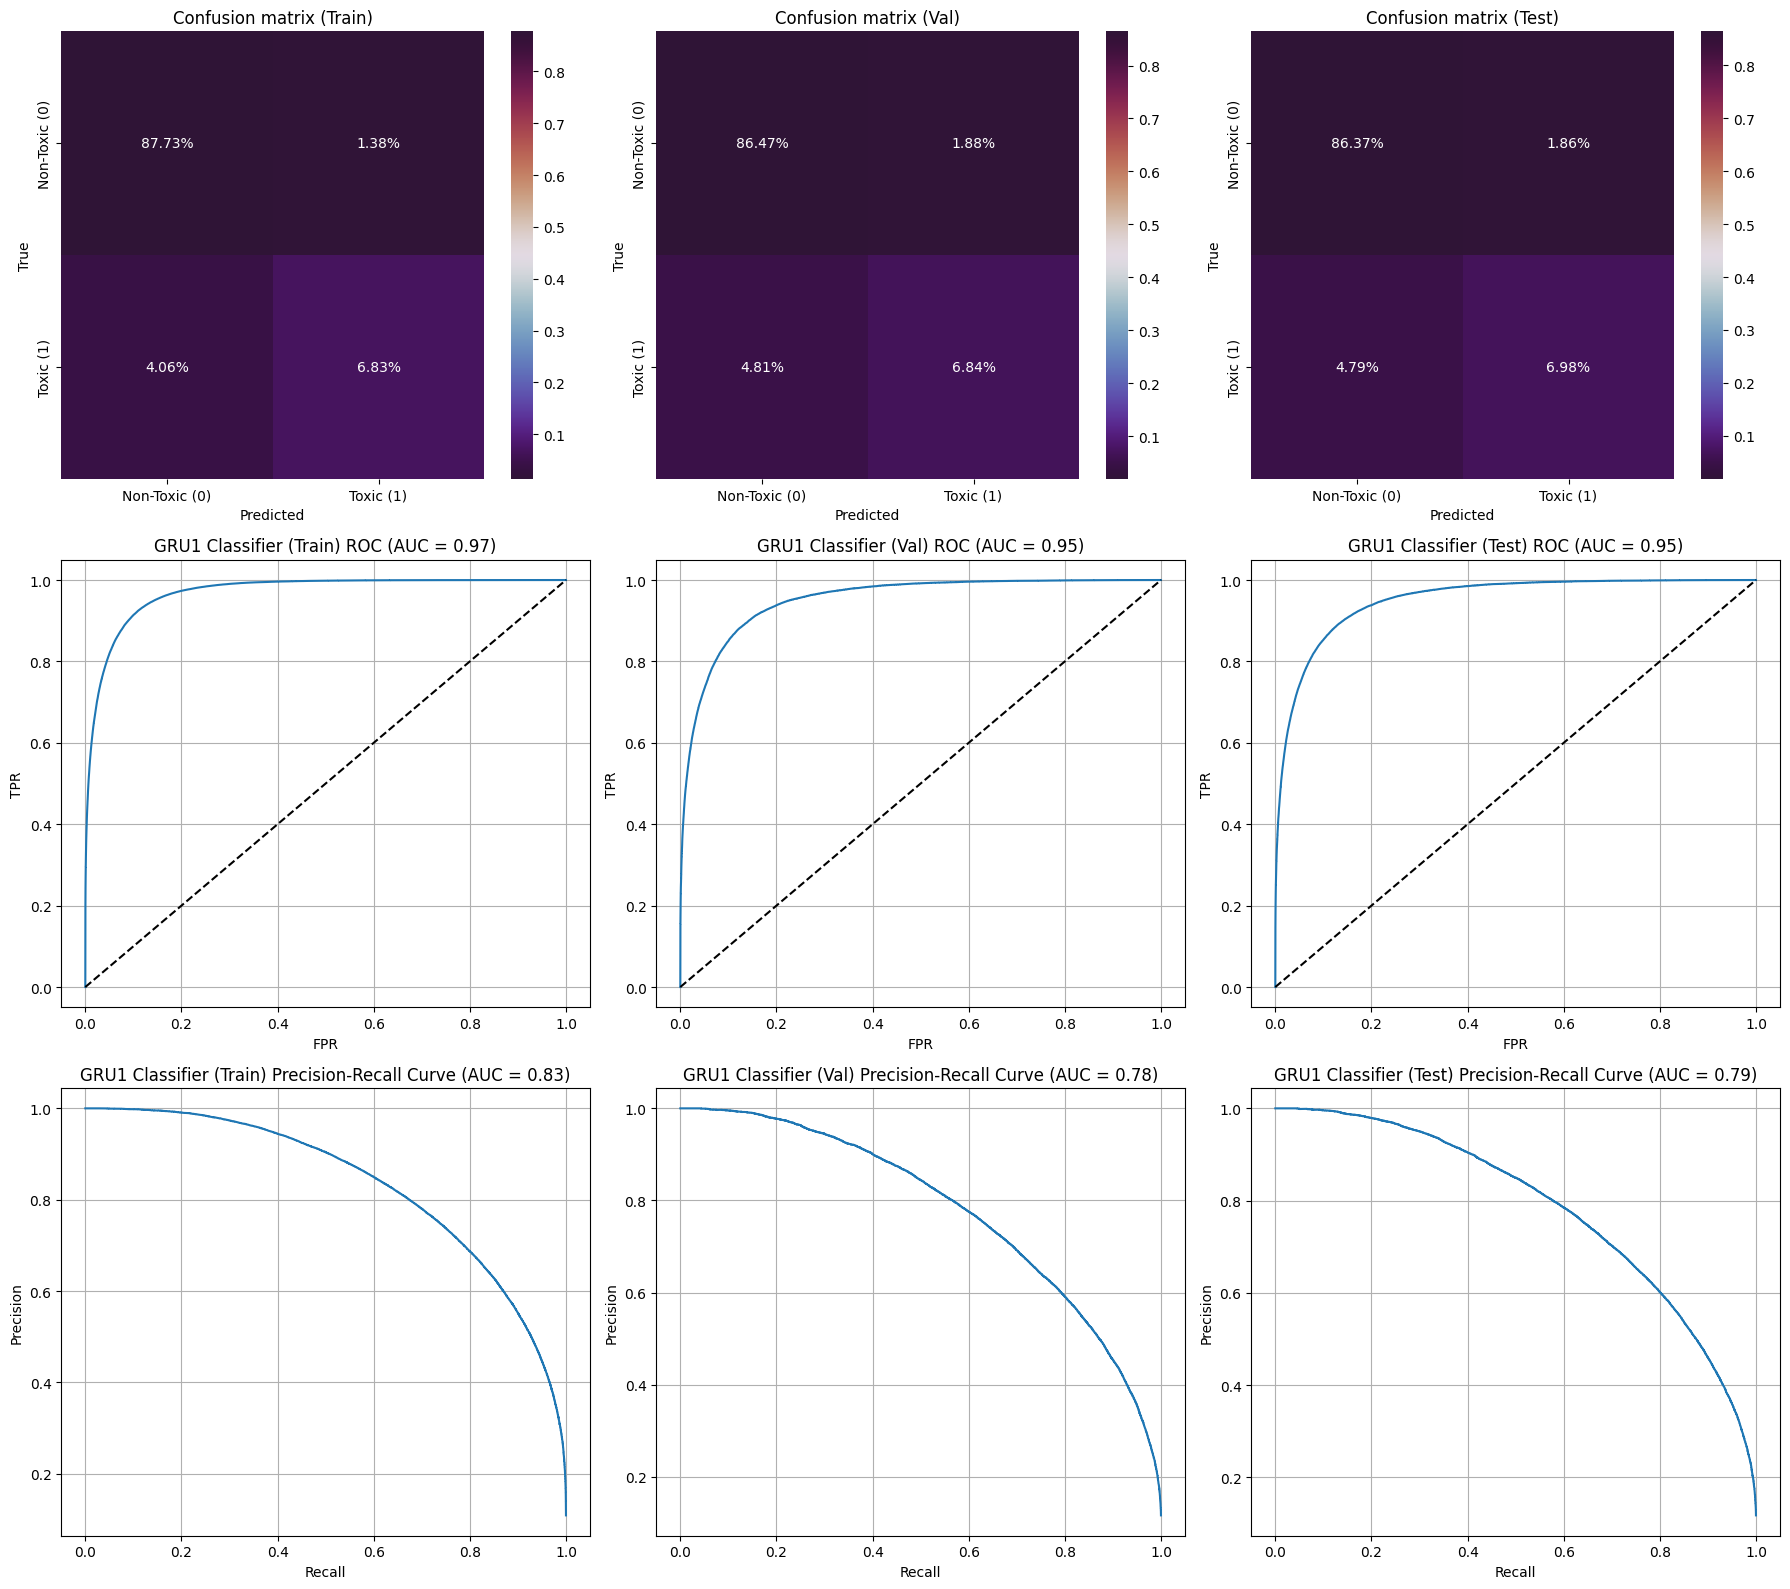

In [15]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="GRU1 Classifier"
)

In [16]:
def find_best_t(y_prob, y_true):
    best_threshold = 0
    best_f1 = 0
    for threshold in np.arange(0.01, 1.01, 0.01):
        binary_preds = (y_prob > threshold).astype(int)
        f1 = f1_score(y_true, binary_preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Лучший порог: {best_threshold:.4f}")
    print(f"Лучший F1: {best_f1:.4f}")
    return best_threshold

In [17]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3600
Лучший F1: 0.6963


0.36000000000000004

In [18]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

102935

**GRU 2 Layers**

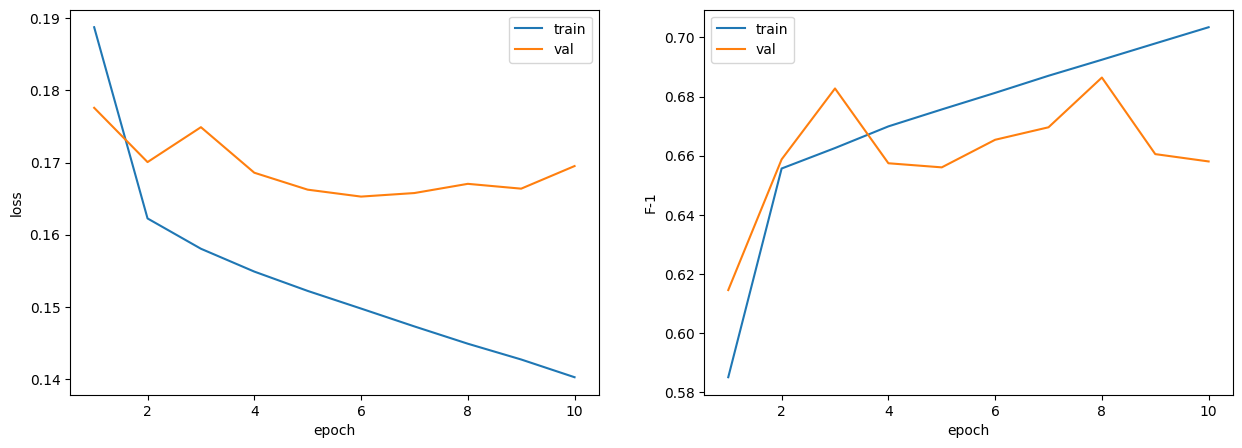

Best Validation Loss: 0.1653 (model saved to GRU2_best.pth)


In [48]:
model = GRUClassifier(num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='GRU2_best.pth'
)

In [49]:
model.load_state_dict(torch.load('GRU2_best.pth'))

<All keys matched successfully>

GRU 2 Classifier

Precision		Recall			F1

Train: 0.82		Train: 0.61		Train: 0.70
Val: 0.79		Val: 0.59		Val: 0.67
Test: 0.79		Test: 0.59		Test: 0.68


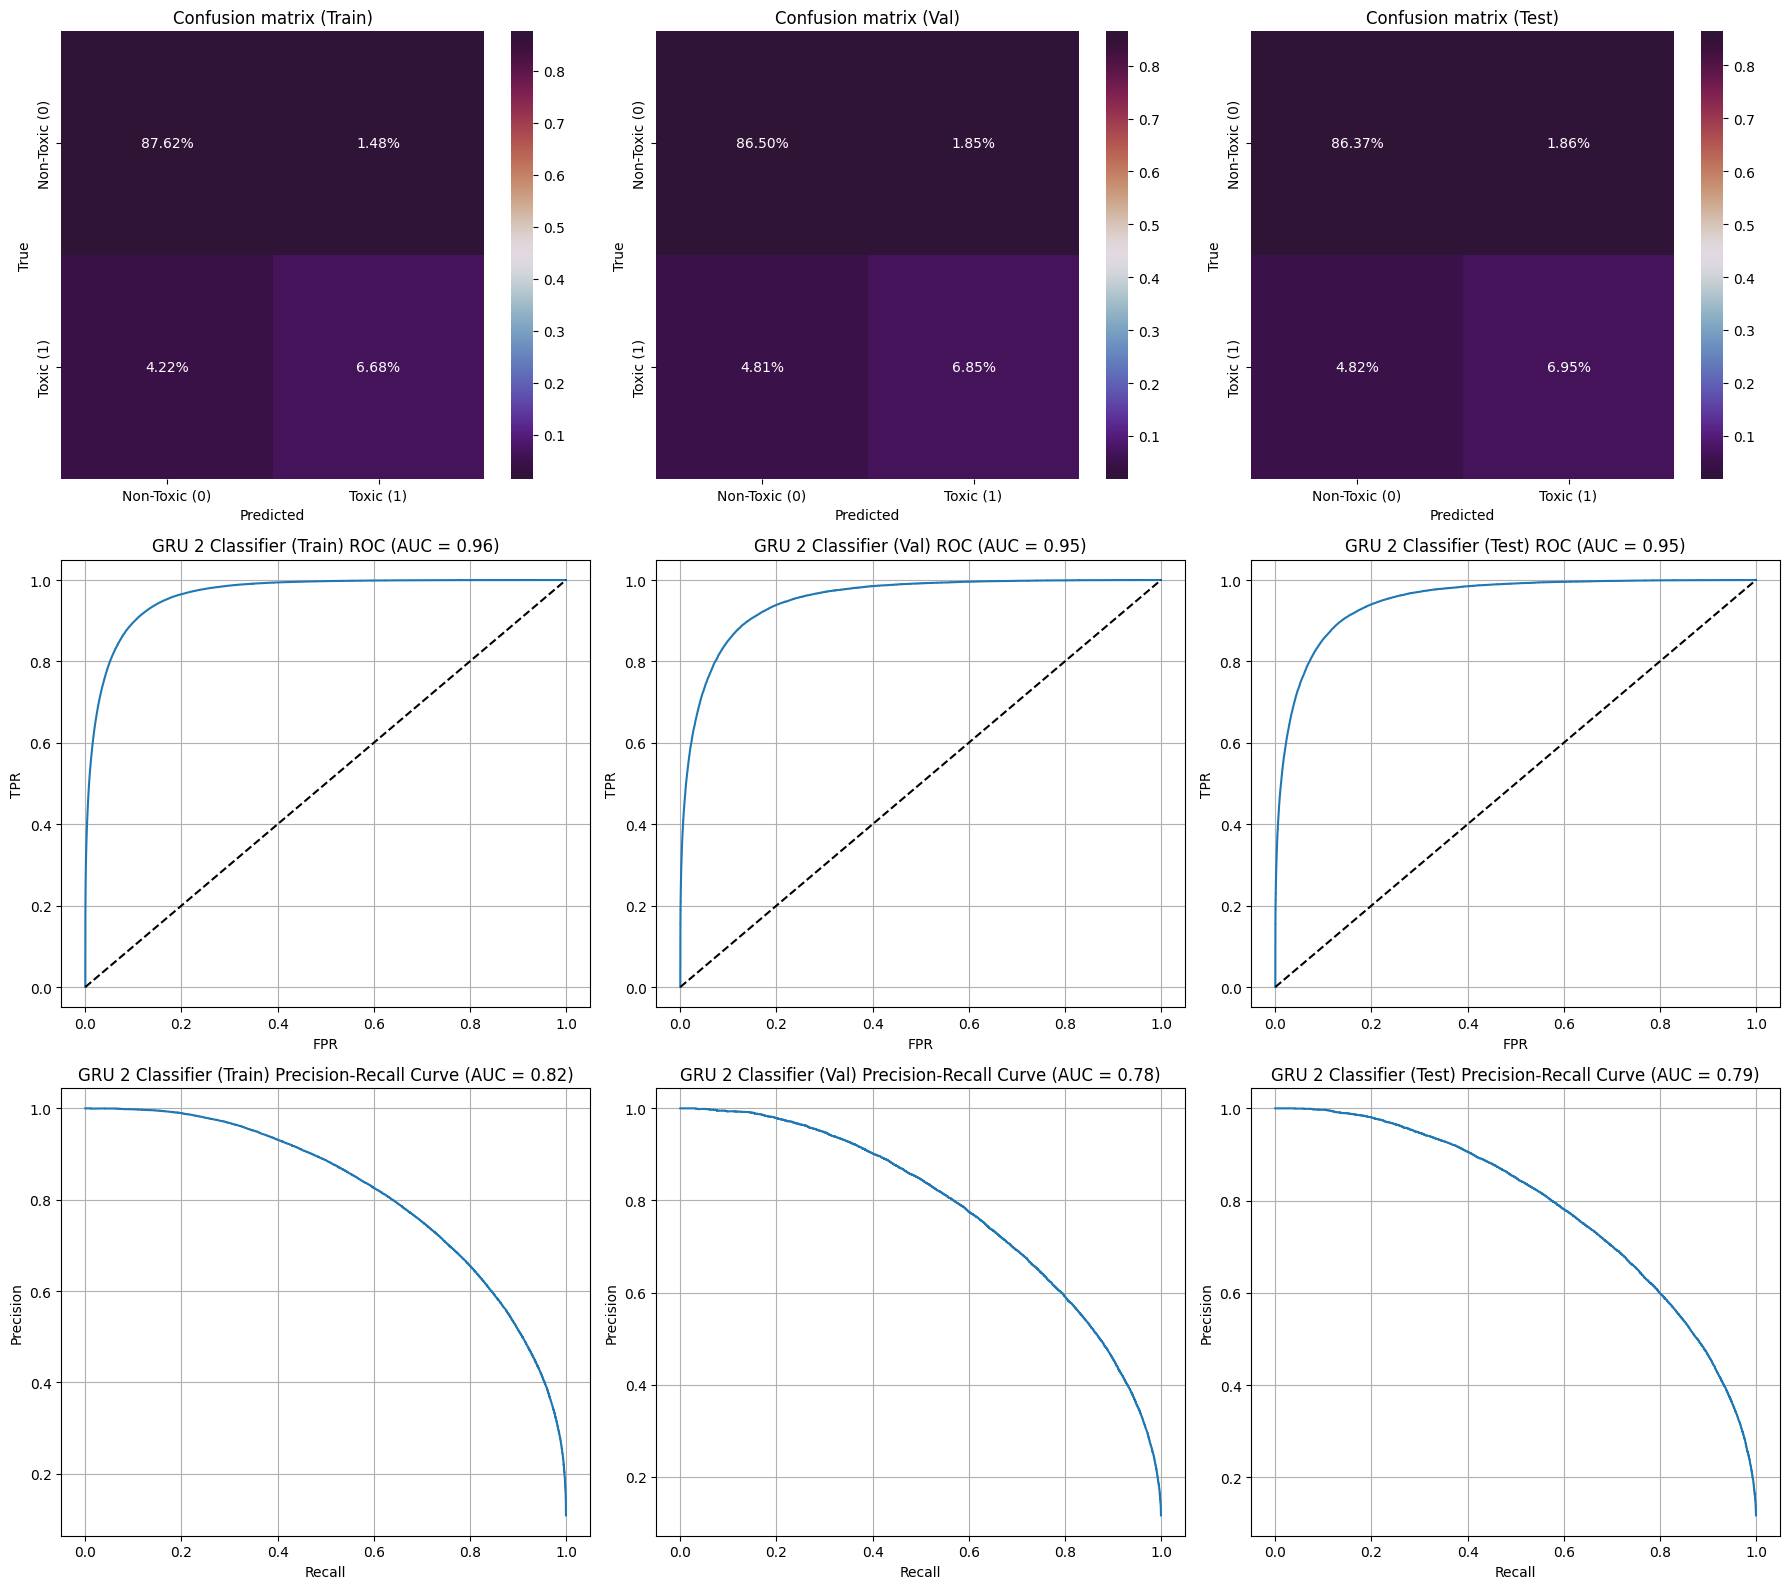

In [50]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="GRU 2 Classifier"
)

In [51]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3100
Лучший F1: 0.6967


0.31

In [52]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

94541

### BiGRU

In [12]:
class BiGRUClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=40734,
        embedding_size=512,
        hidden_size=256,
        num_classes=1,
        num_layers=1,
        pad_token=1,
        dropout=0.5,
        mode='last'  # ['last', 'avgpool', 'maxpool', 'attention', 'concat']
    ):
        super(BiGRUClassifier, self).__init__()

        self.mode = mode
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(
            num_embeddings, embedding_size, padding_idx=pad_token
        )

        self.gru = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        self.dropout = nn.Dropout(dropout)

        if mode == 'concat':
            fc_input_dim = hidden_size * 6
        else:
            fc_input_dim = hidden_size * 2

        self.linear = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))  # [B, T, E]
        gru_out, hidden = self.gru(embedded)  # gru_out: [B, T, 2H], hidden: [2L, B, H]

        if self.mode == 'last':
            rep = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]

        elif self.mode == 'avgpool':
            rep = torch.mean(gru_out, dim=1)  # [B, 2H]

        elif self.mode == 'maxpool':
            rep = torch.max(gru_out, dim=1)[0]  # [B, 2H]

        elif self.mode == 'attention':
            scores = torch.tanh(gru_out)  # [B, T, 2H]
            attn_weights = torch.matmul(scores, torch.ones(scores.shape[2], 1, device=x.device))  # [B, T, 1]
            attn_weights = torch.softmax(attn_weights, dim=1)
            rep = torch.sum(attn_weights * gru_out, dim=1)  # [B, 2H]

        elif self.mode == 'concat':
            last = torch.cat((hidden[-2], hidden[-1]), dim=1)
            avg = torch.mean(gru_out, dim=1)
            maxp = torch.max(gru_out, dim=1)[0]
            rep = torch.cat([last, avg, maxp], dim=1)  # [B, 6H]

        else:
            raise ValueError(f"Unknown mode: {self.mode}")

        out = self.linear(self.dropout(rep))  # [B, 1]
        return out.squeeze(1)

**BiGRU Base**

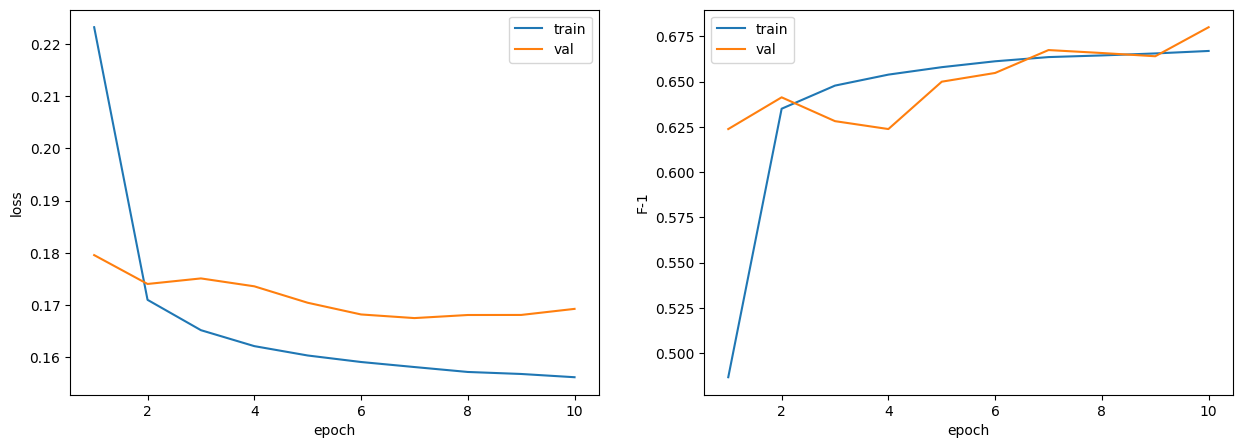

Best Validation Loss: 0.1675 (model saved to BiGRU1_best.pth)


In [13]:
model = BiGRUClassifier(num_layers=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiGRU1_best.pth'
)

In [14]:
model.load_state_dict(torch.load('BiGRU1_best.pth'))

<All keys matched successfully>

BiGRU Classifier

Precision		Recall			F1

Train: 0.79		Train: 0.62		Train: 0.70
Val: 0.77		Val: 0.60		Val: 0.67
Test: 0.77		Test: 0.60		Test: 0.68


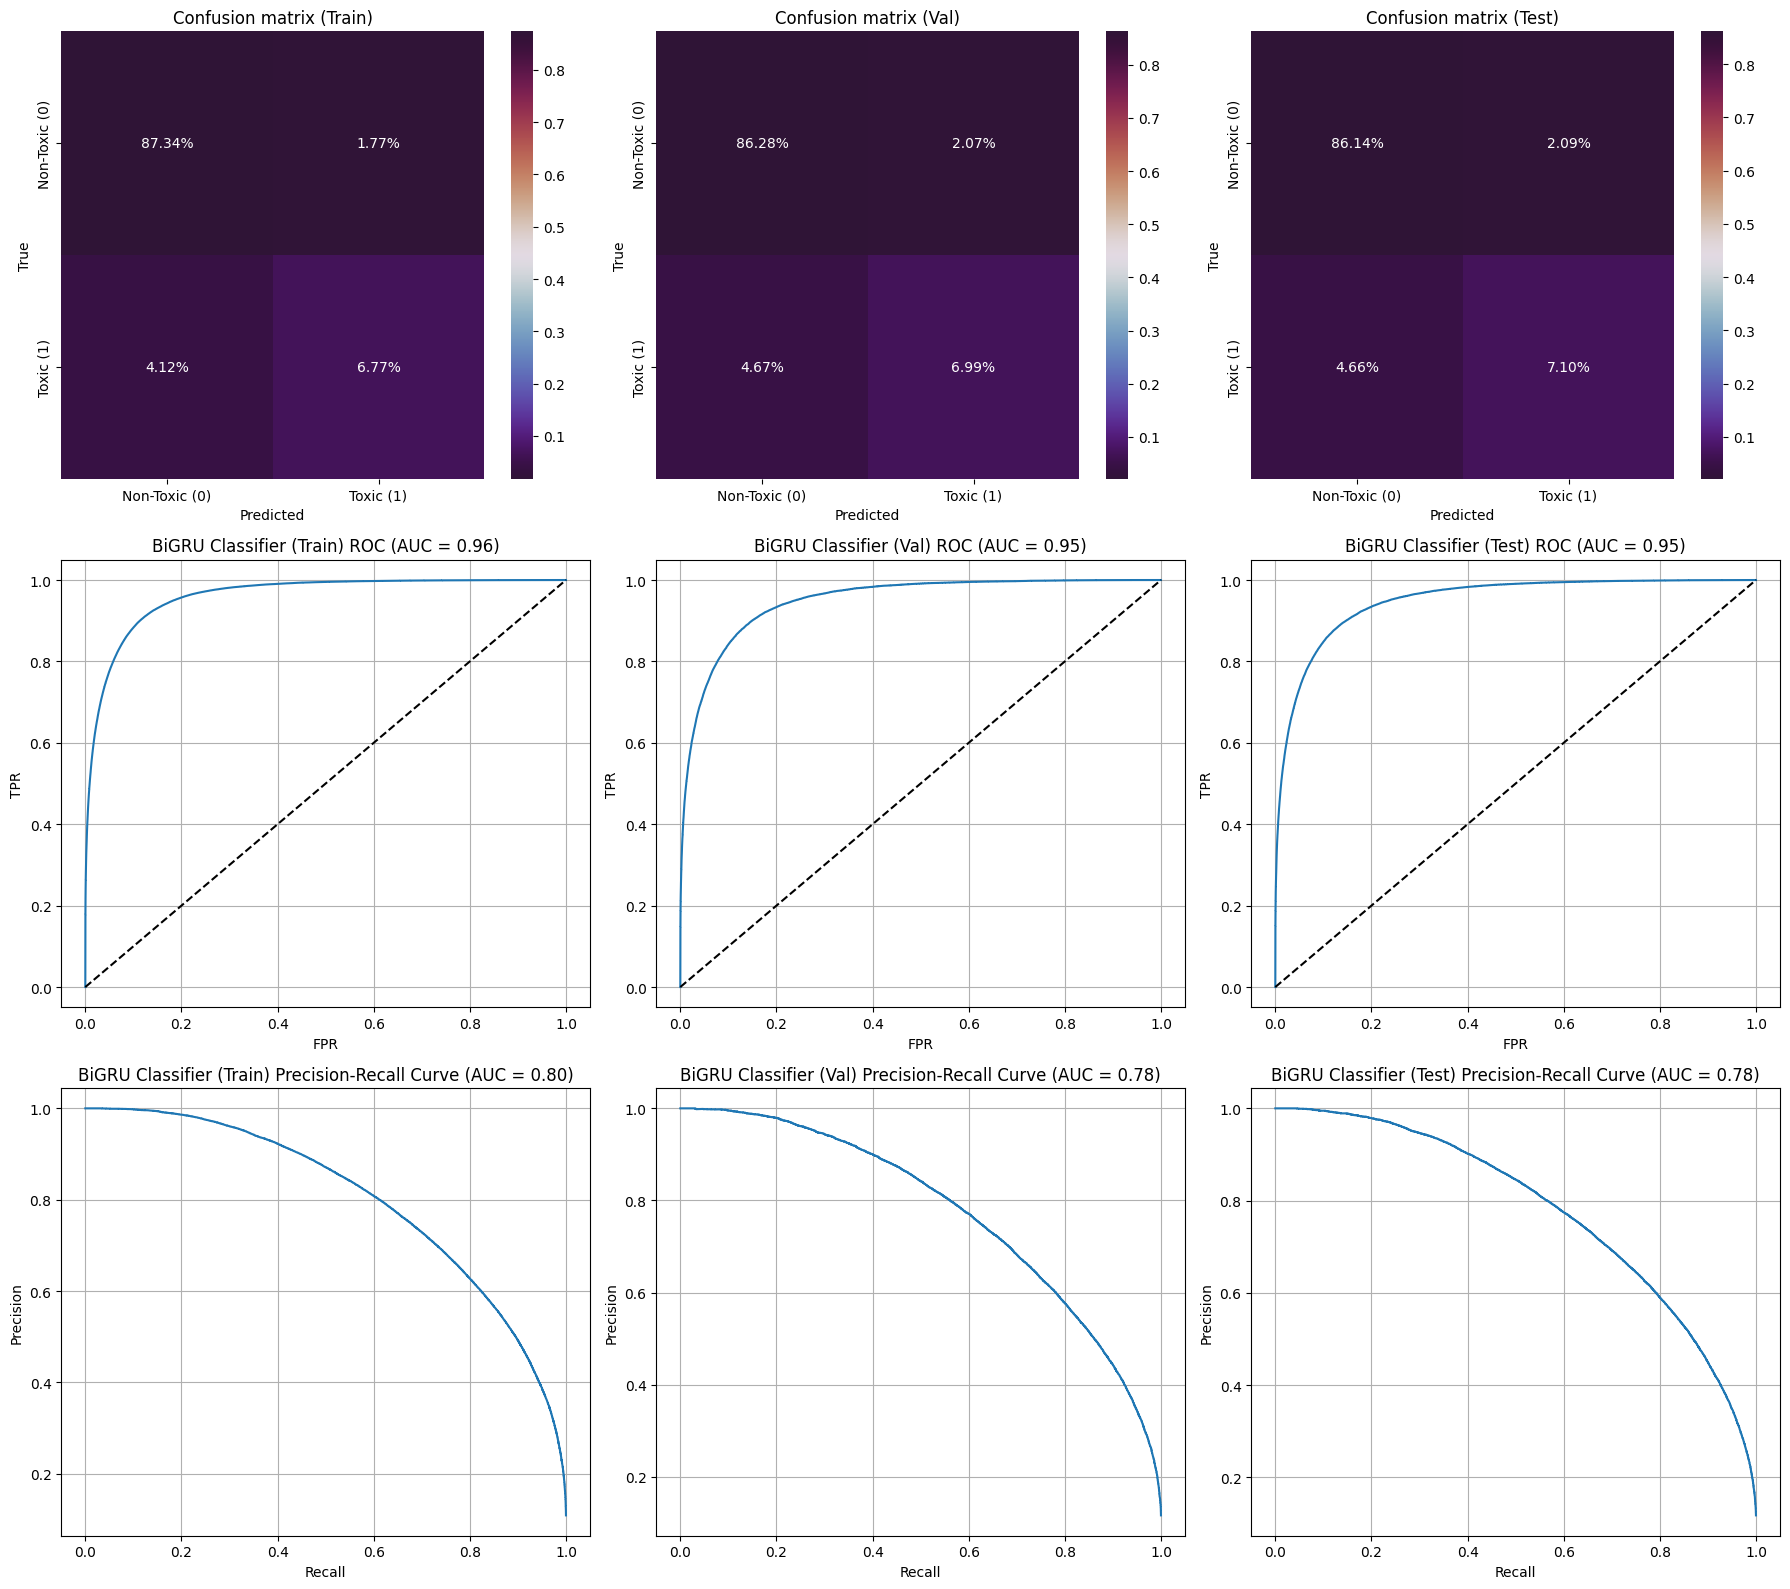

In [15]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiGRU Classifier"
)

In [16]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3700
Лучший F1: 0.6919


0.37

In [17]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

103806

**Stacked BiGRU**

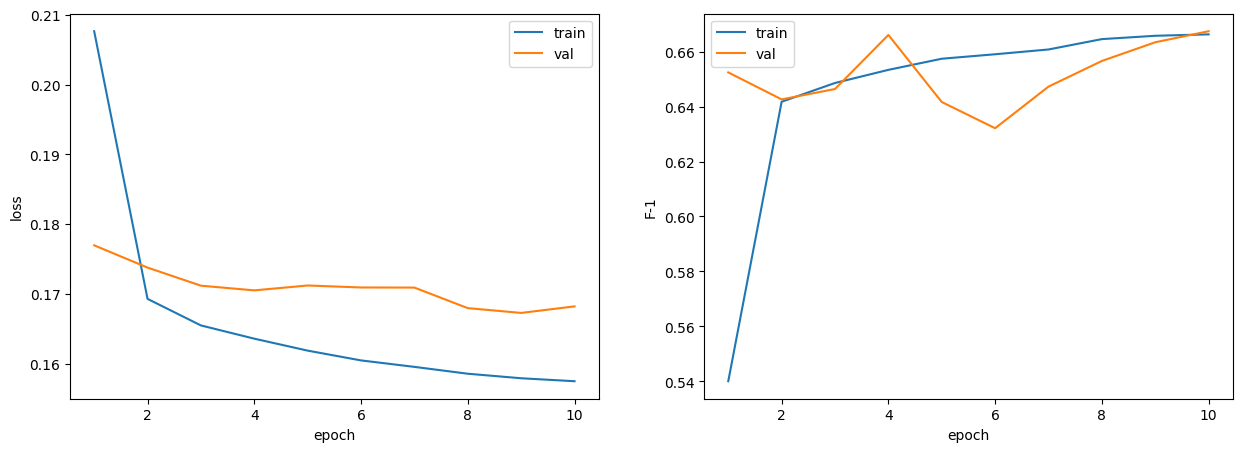

Best Validation Loss: 0.1673 (model saved to BiGRU2_best.pth)


In [18]:
model = BiGRUClassifier(num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiGRU2_best.pth'
)

In [19]:
model.load_state_dict(torch.load('BiGRU2_best.pth'))

<All keys matched successfully>

BiGRU2 Classifier

Precision		Recall			F1

Train: 0.80		Train: 0.61		Train: 0.70
Val: 0.77		Val: 0.59		Val: 0.67
Test: 0.78		Test: 0.60		Test: 0.68


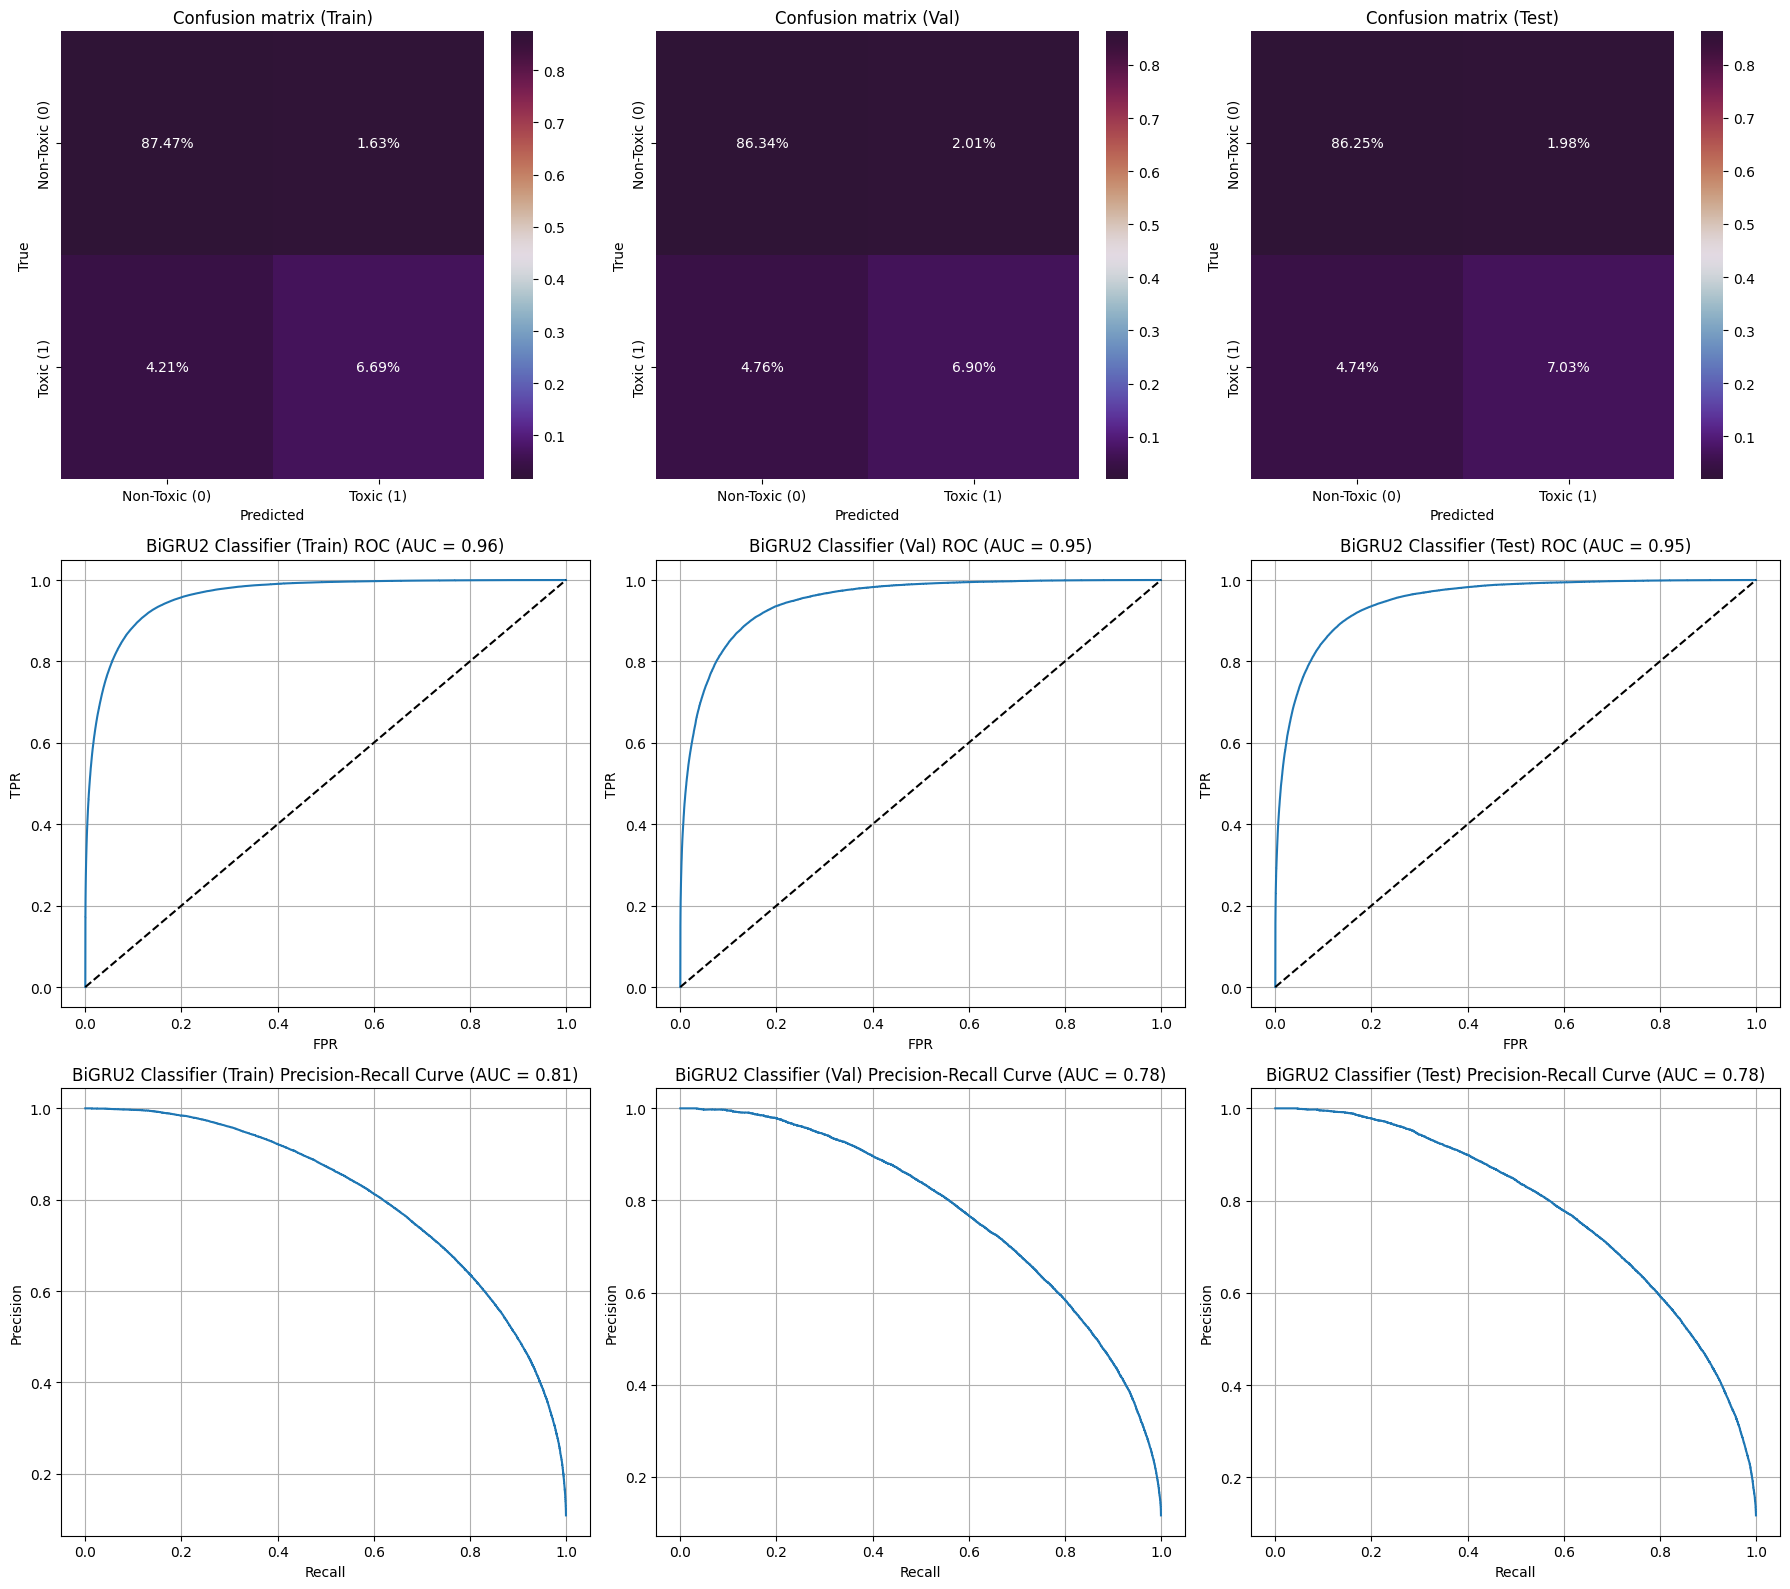

In [20]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiGRU2 Classifier"
)

In [21]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3700
Лучший F1: 0.6935


0.37

In [22]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

94323

**BiGRU AvgPool**

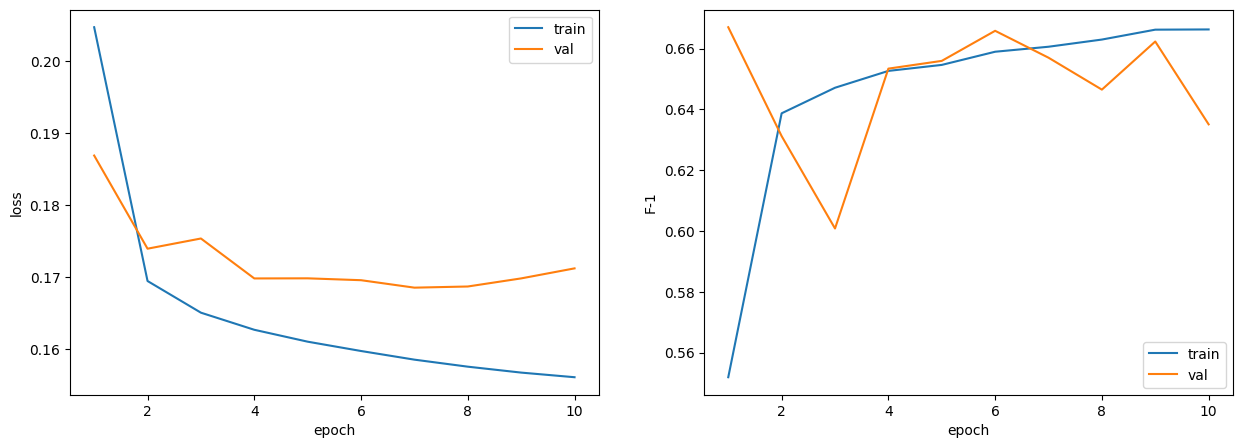

Best Validation Loss: 0.1685 (model saved to BiGRU3_best.pth)


In [23]:
model = BiGRUClassifier(num_layers=2, mode = 'avgpool').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiGRU3_best.pth'
)

In [24]:
model.load_state_dict(torch.load('BiGRU3_best.pth'))

<All keys matched successfully>

BiGRU3 Classifier

Precision		Recall			F1

Train: 0.81		Train: 0.59		Train: 0.69
Val: 0.79		Val: 0.58		Val: 0.66
Test: 0.79		Test: 0.58		Test: 0.67


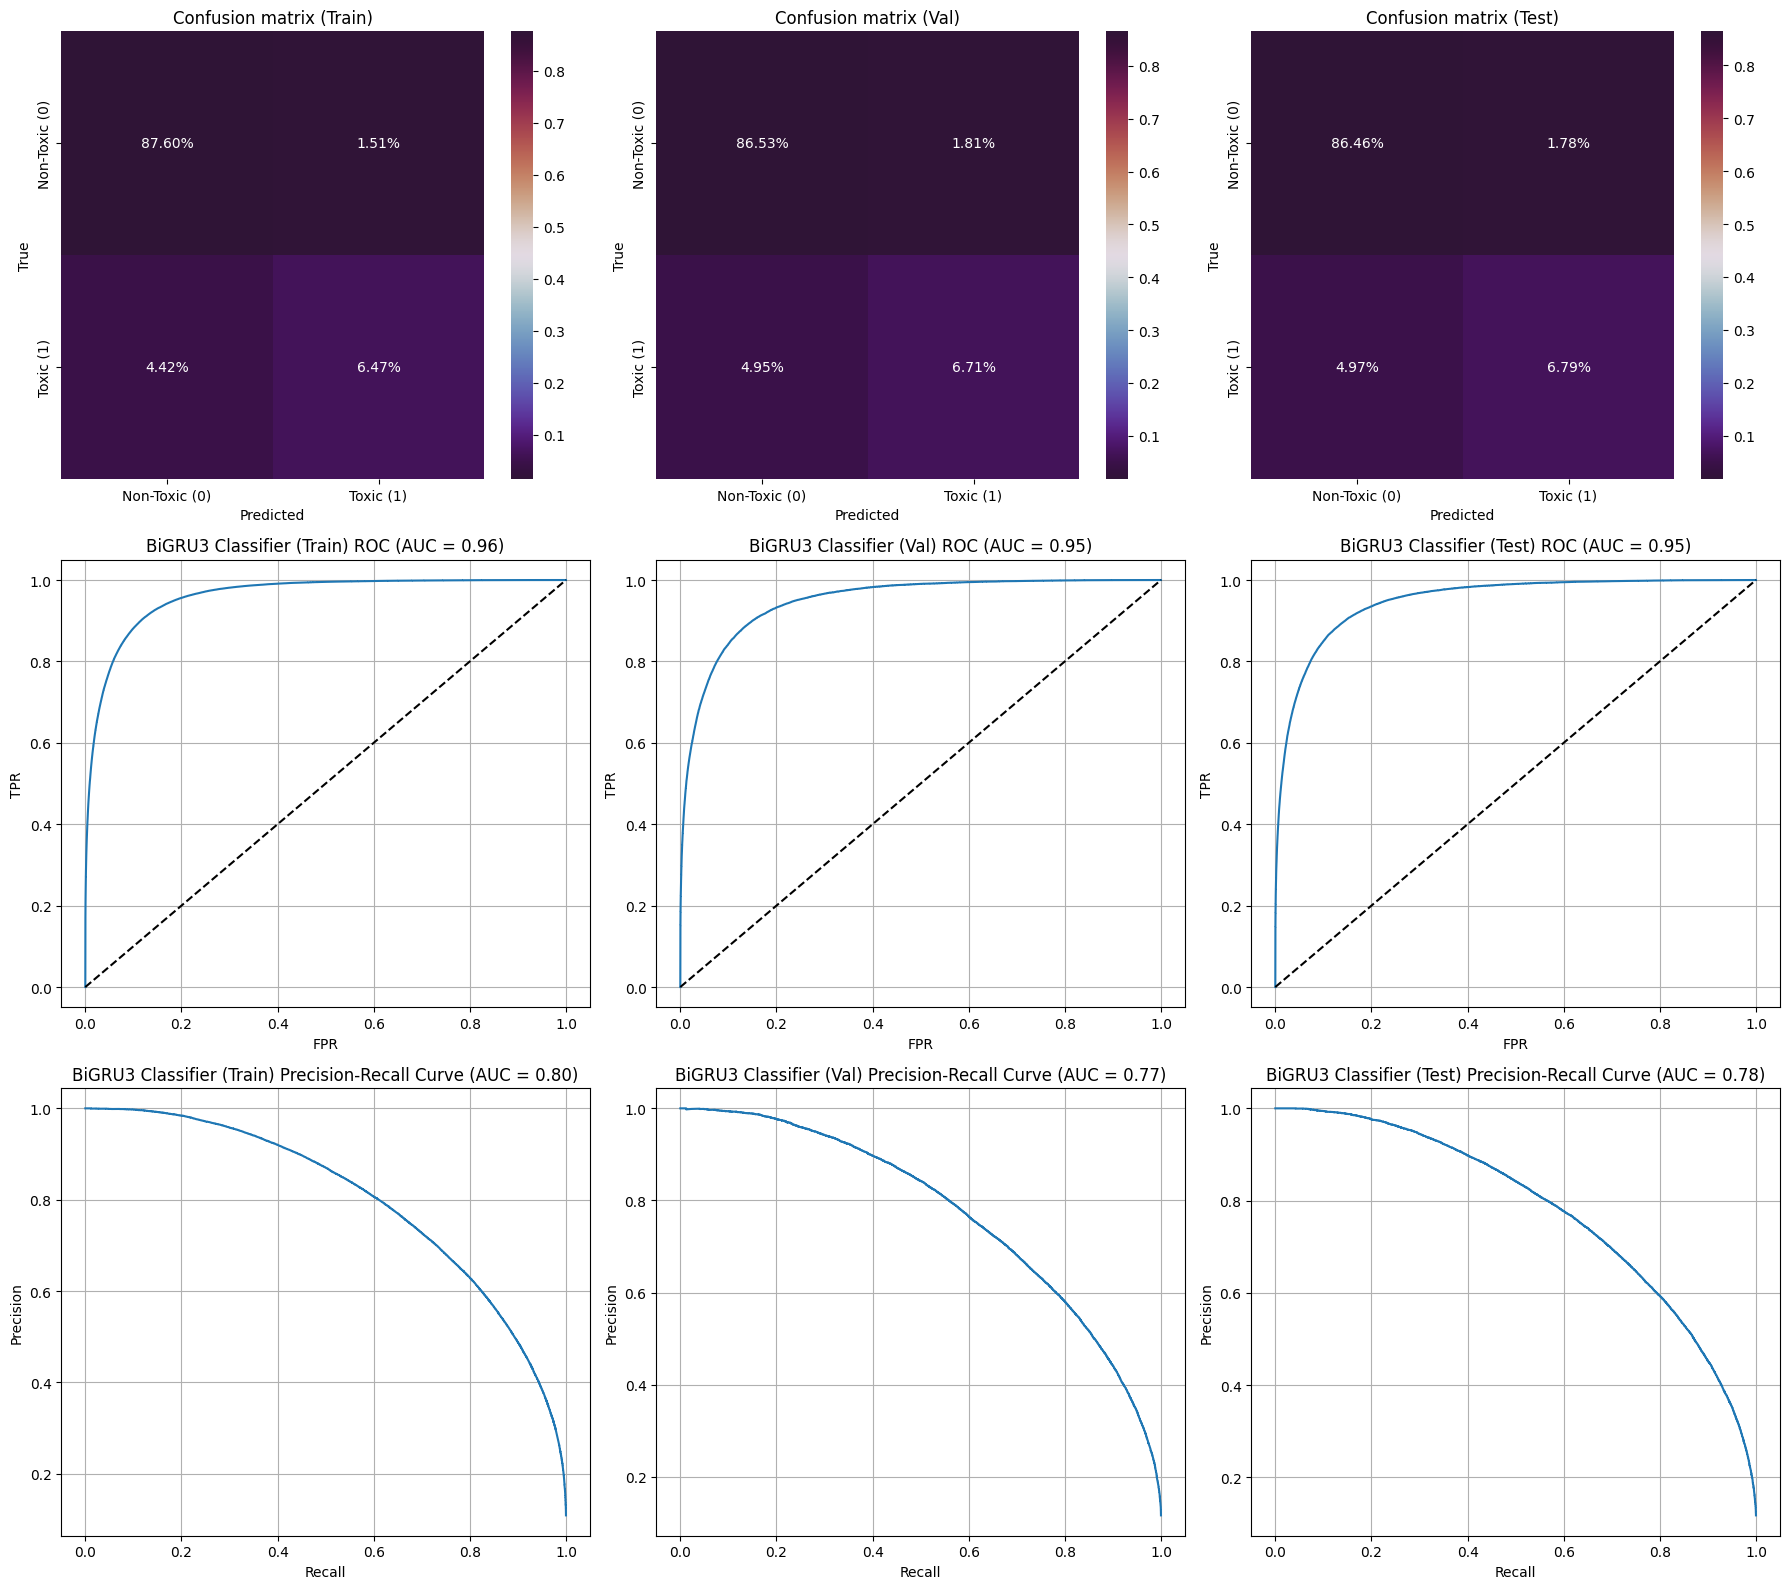

In [25]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiGRU3 Classifier"
)

In [26]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3500
Лучший F1: 0.6908


0.35000000000000003

In [27]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

93938

**BiGRU MaxPool**

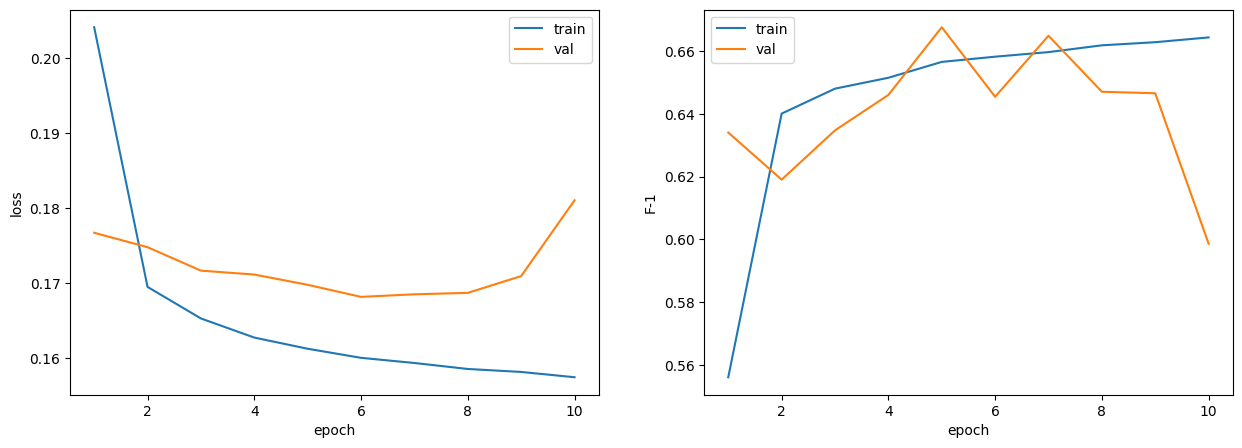

Best Validation Loss: 0.1681 (model saved to BiGRU4_best.pth)


In [28]:
model = BiGRUClassifier(num_layers=2, mode = 'maxpool').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiGRU4_best.pth'
)

In [29]:
model.load_state_dict(torch.load('BiGRU4_best.pth'))

<All keys matched successfully>

BiGRU4 Classifier

Precision		Recall			F1

Train: 0.82		Train: 0.57		Train: 0.67
Val: 0.80		Val: 0.55		Val: 0.65
Test: 0.81		Test: 0.56		Test: 0.66


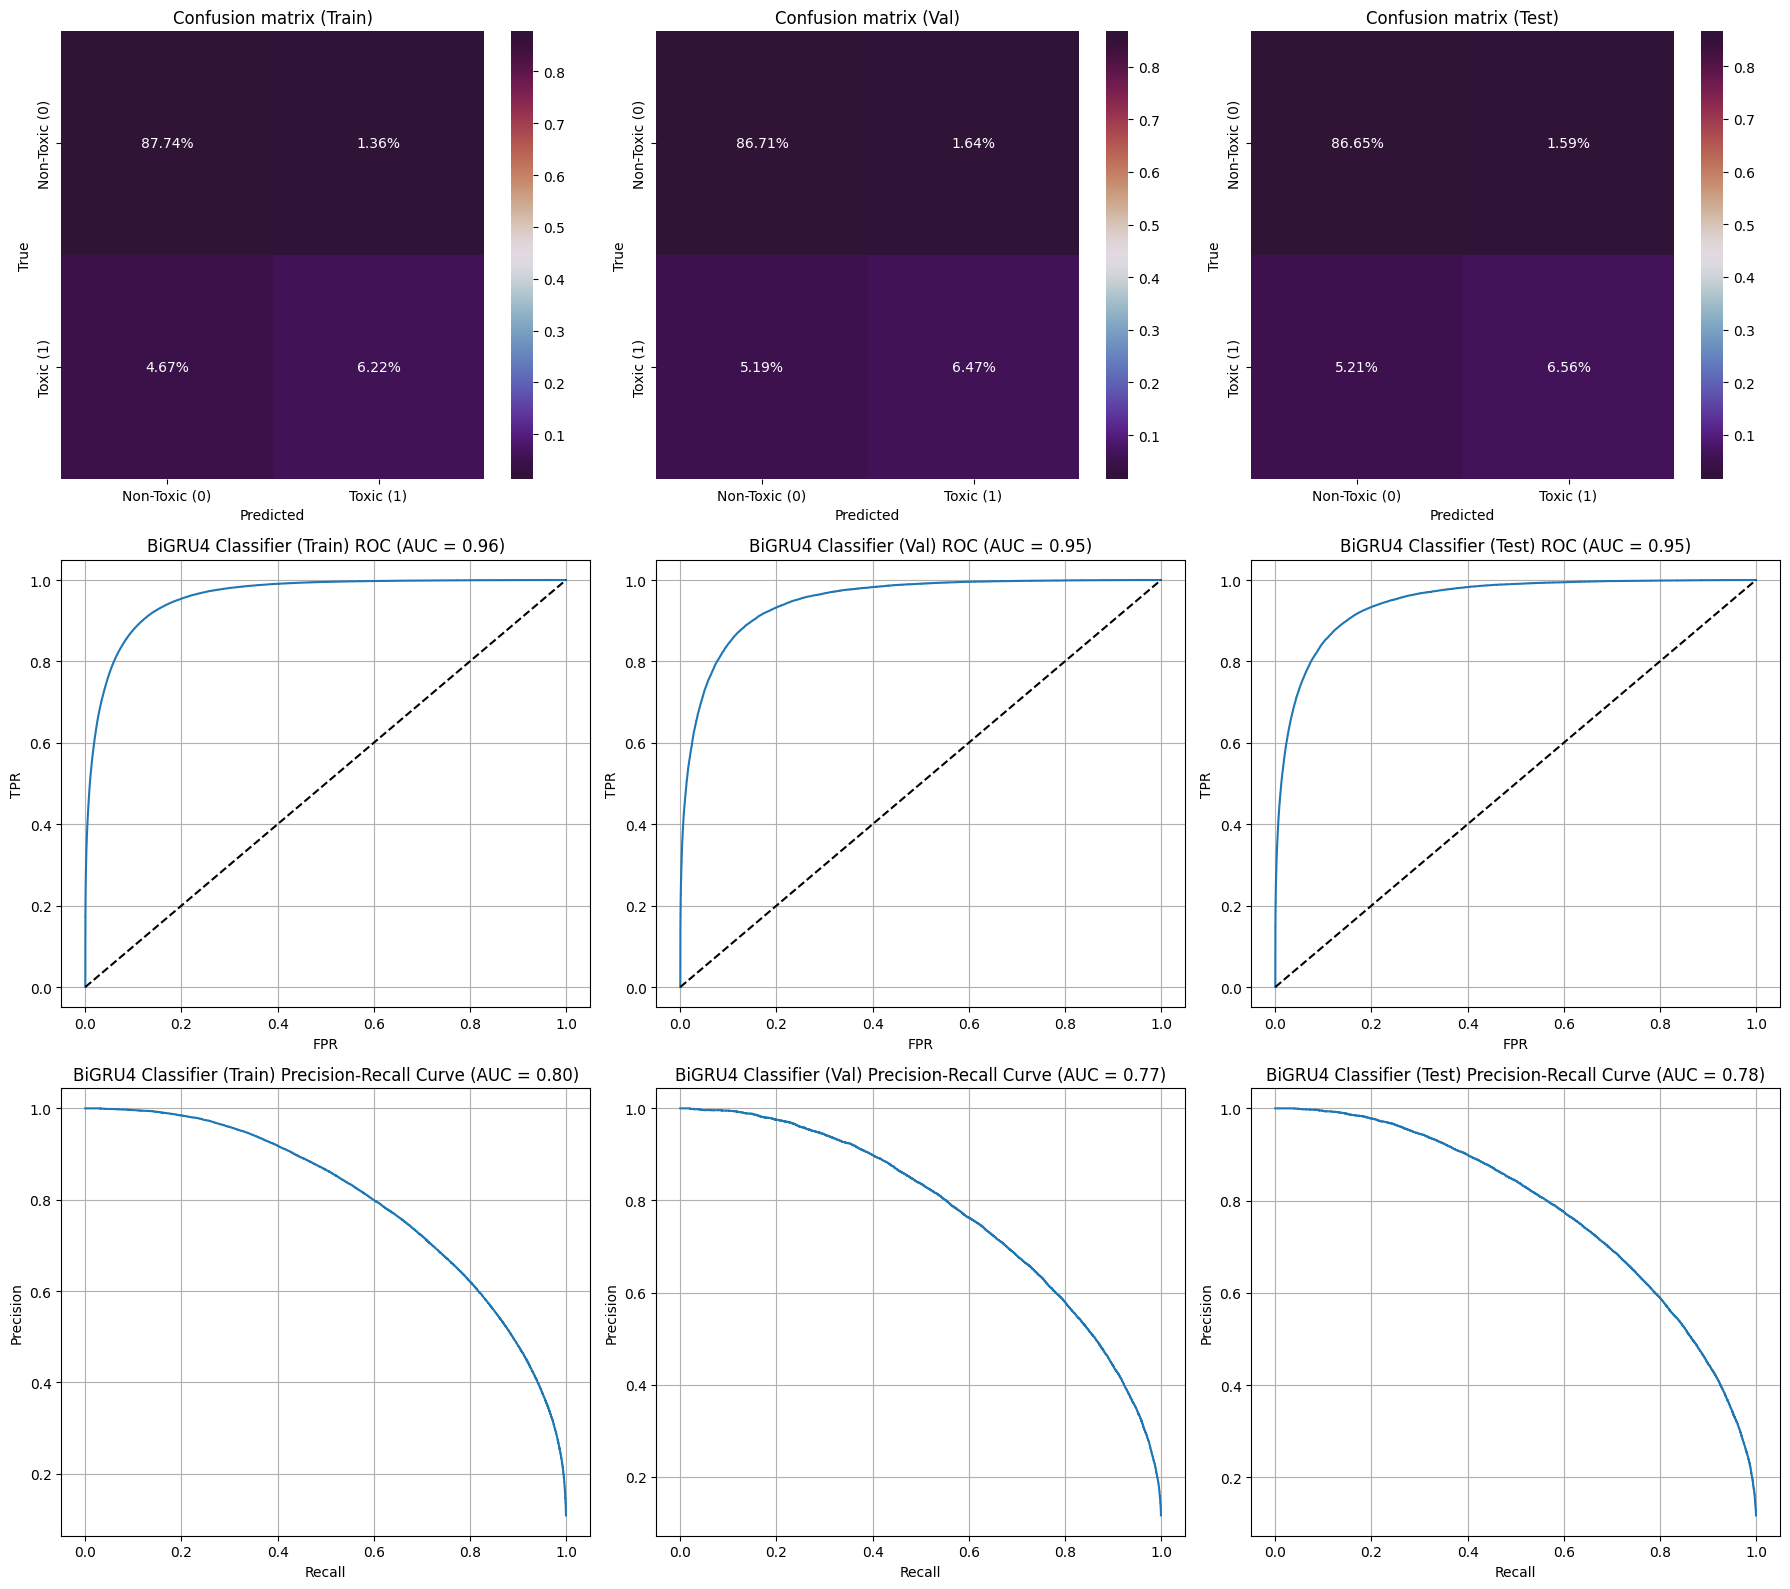

In [30]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiGRU4 Classifier"
)

In [31]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3000
Лучший F1: 0.6906


0.3

In [32]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

99952

**BiGRU Attention**

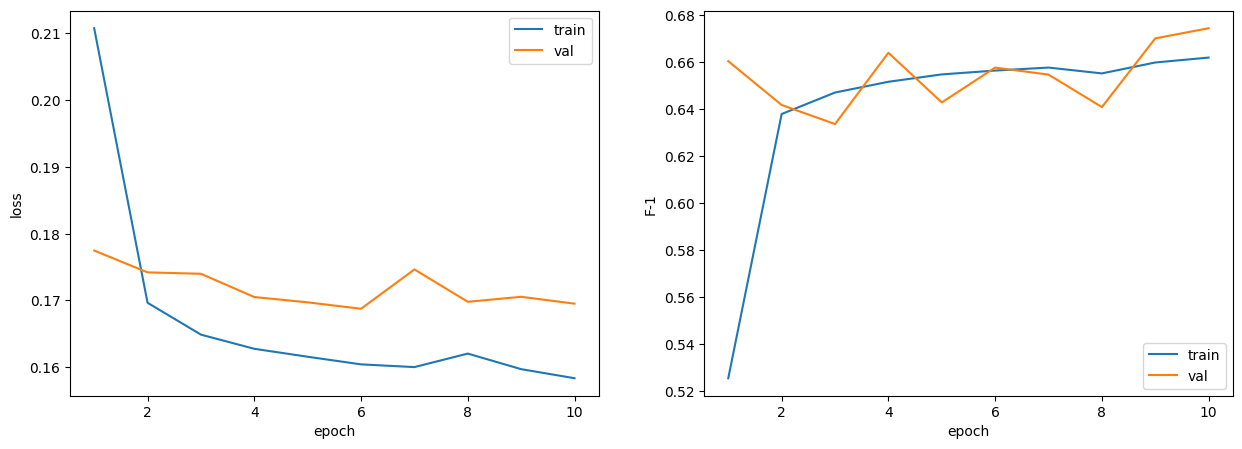

Best Validation Loss: 0.1688 (model saved to BiGRU5_best.pth)


In [33]:
model = BiGRUClassifier(num_layers=2, mode = 'attention').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiGRU5_best.pth'
)

In [34]:
model.load_state_dict(torch.load('BiGRU5_best.pth'))

<All keys matched successfully>

BiGRU5 Classifier

Precision		Recall			F1

Train: 0.80		Train: 0.60		Train: 0.68
Val: 0.78		Val: 0.58		Val: 0.66
Test: 0.79		Test: 0.58		Test: 0.67


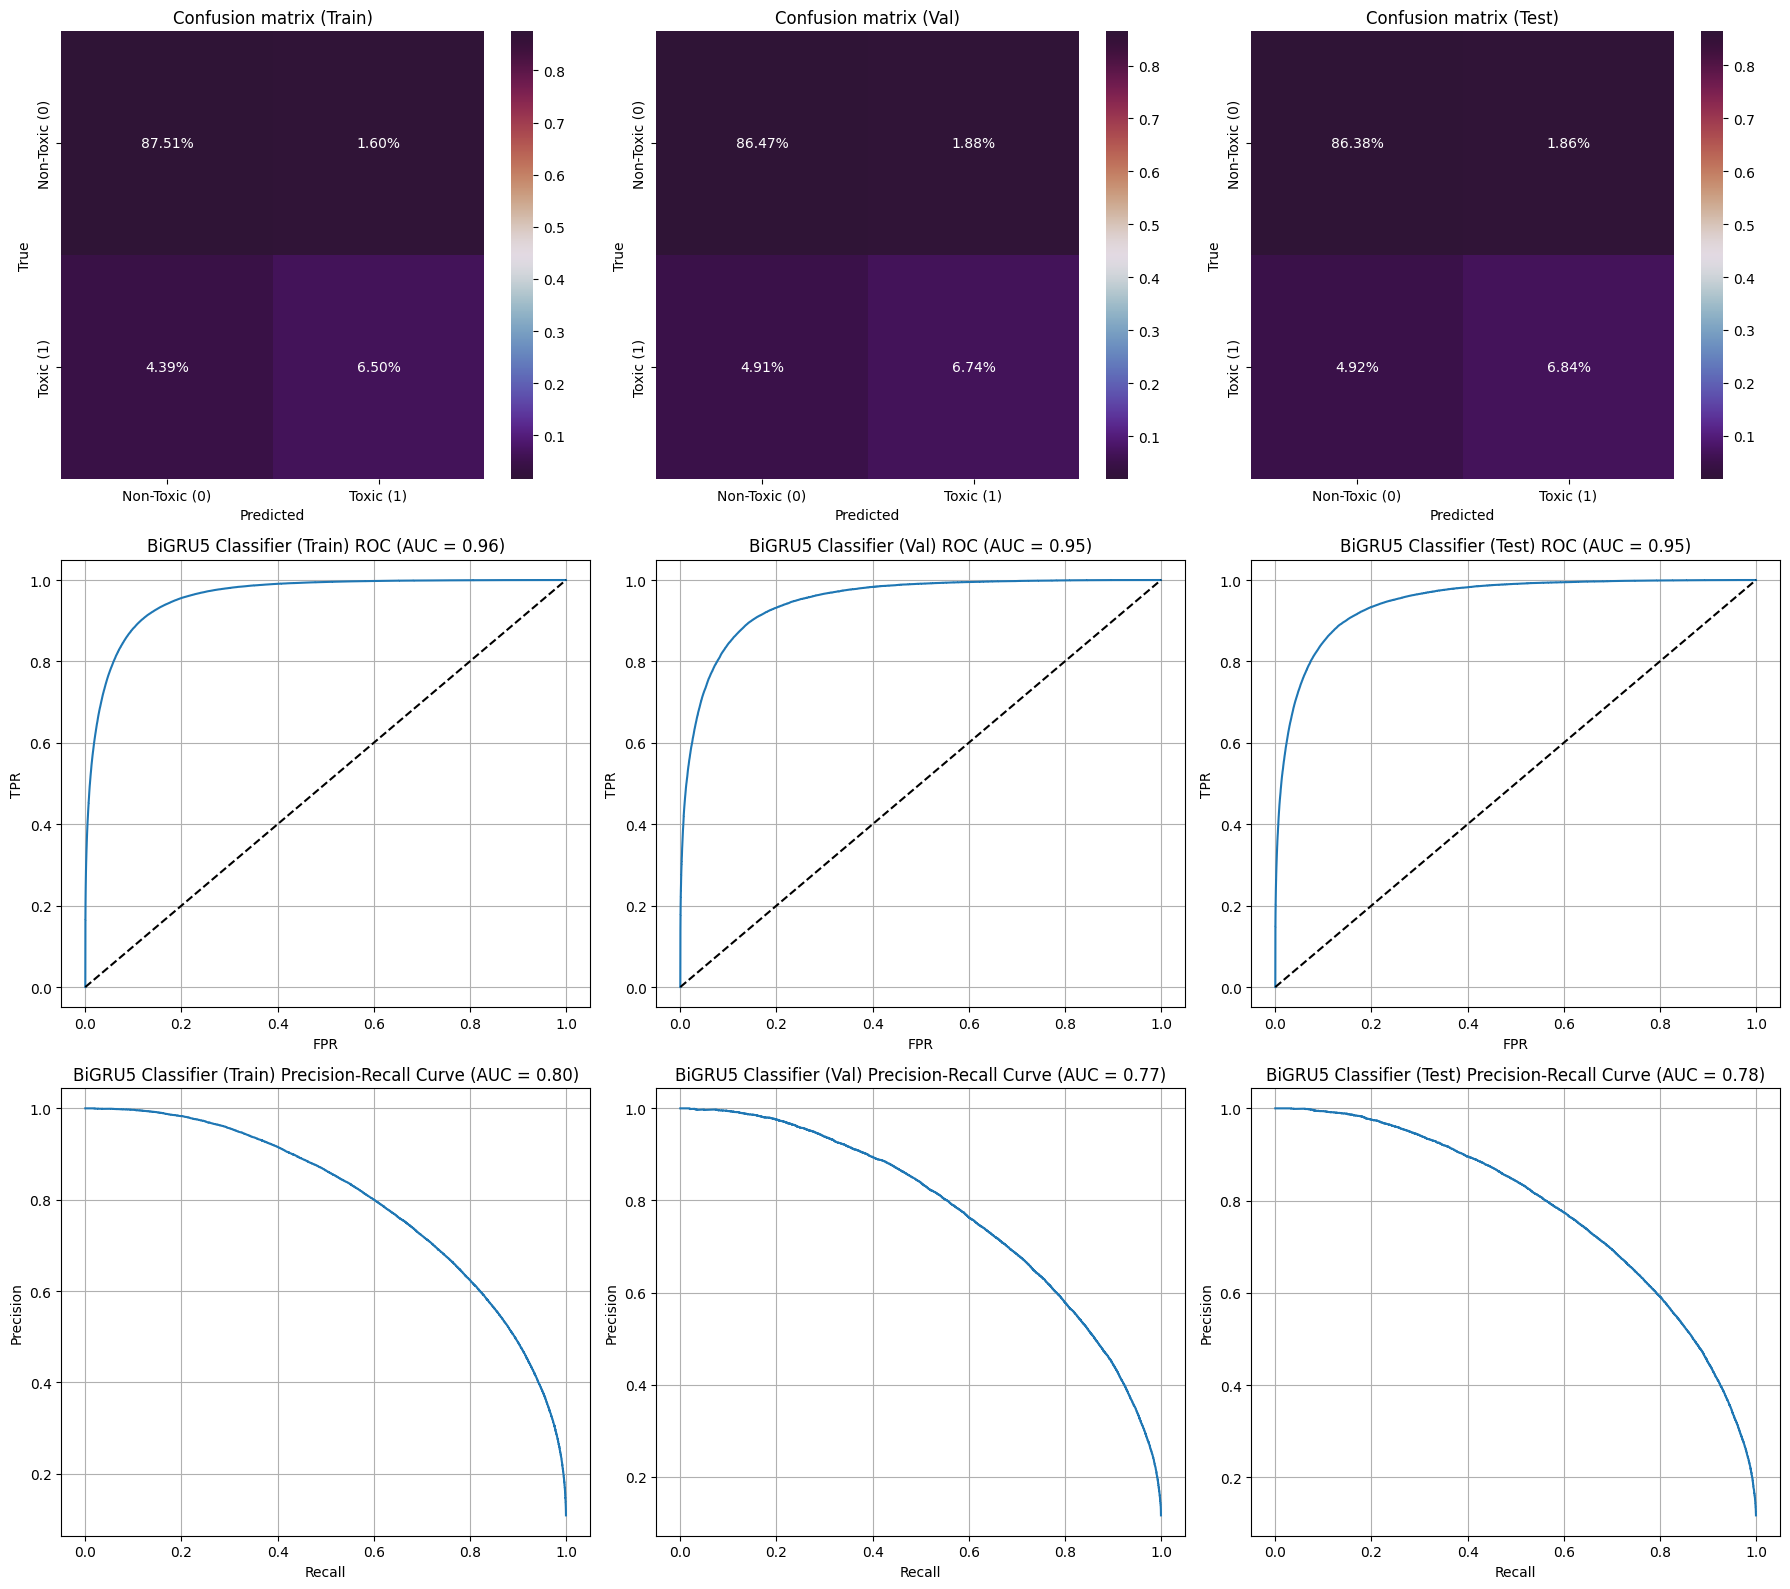

In [35]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiGRU5 Classifier"
)

In [36]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3400
Лучший F1: 0.6922


0.34

In [37]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

102288

**BiGRU Last + AvgPool + MaxPool**

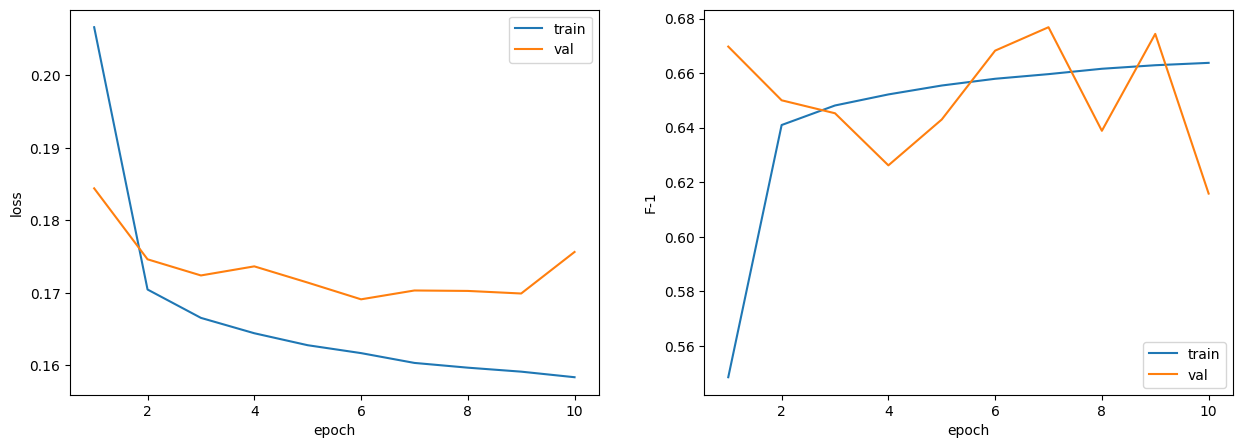

Best Validation Loss: 0.1691 (model saved to BiGRU6_best.pth)


In [38]:
model = BiGRUClassifier(num_layers=2, mode = 'concat').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiGRU6_best.pth'
)

In [39]:
model.load_state_dict(torch.load('BiGRU6_best.pth'))

<All keys matched successfully>

BiGRU6 Classifier

Precision		Recall			F1

Train: 0.78		Train: 0.63		Train: 0.70
Val: 0.76		Val: 0.61		Val: 0.68
Test: 0.76		Test: 0.61		Test: 0.68


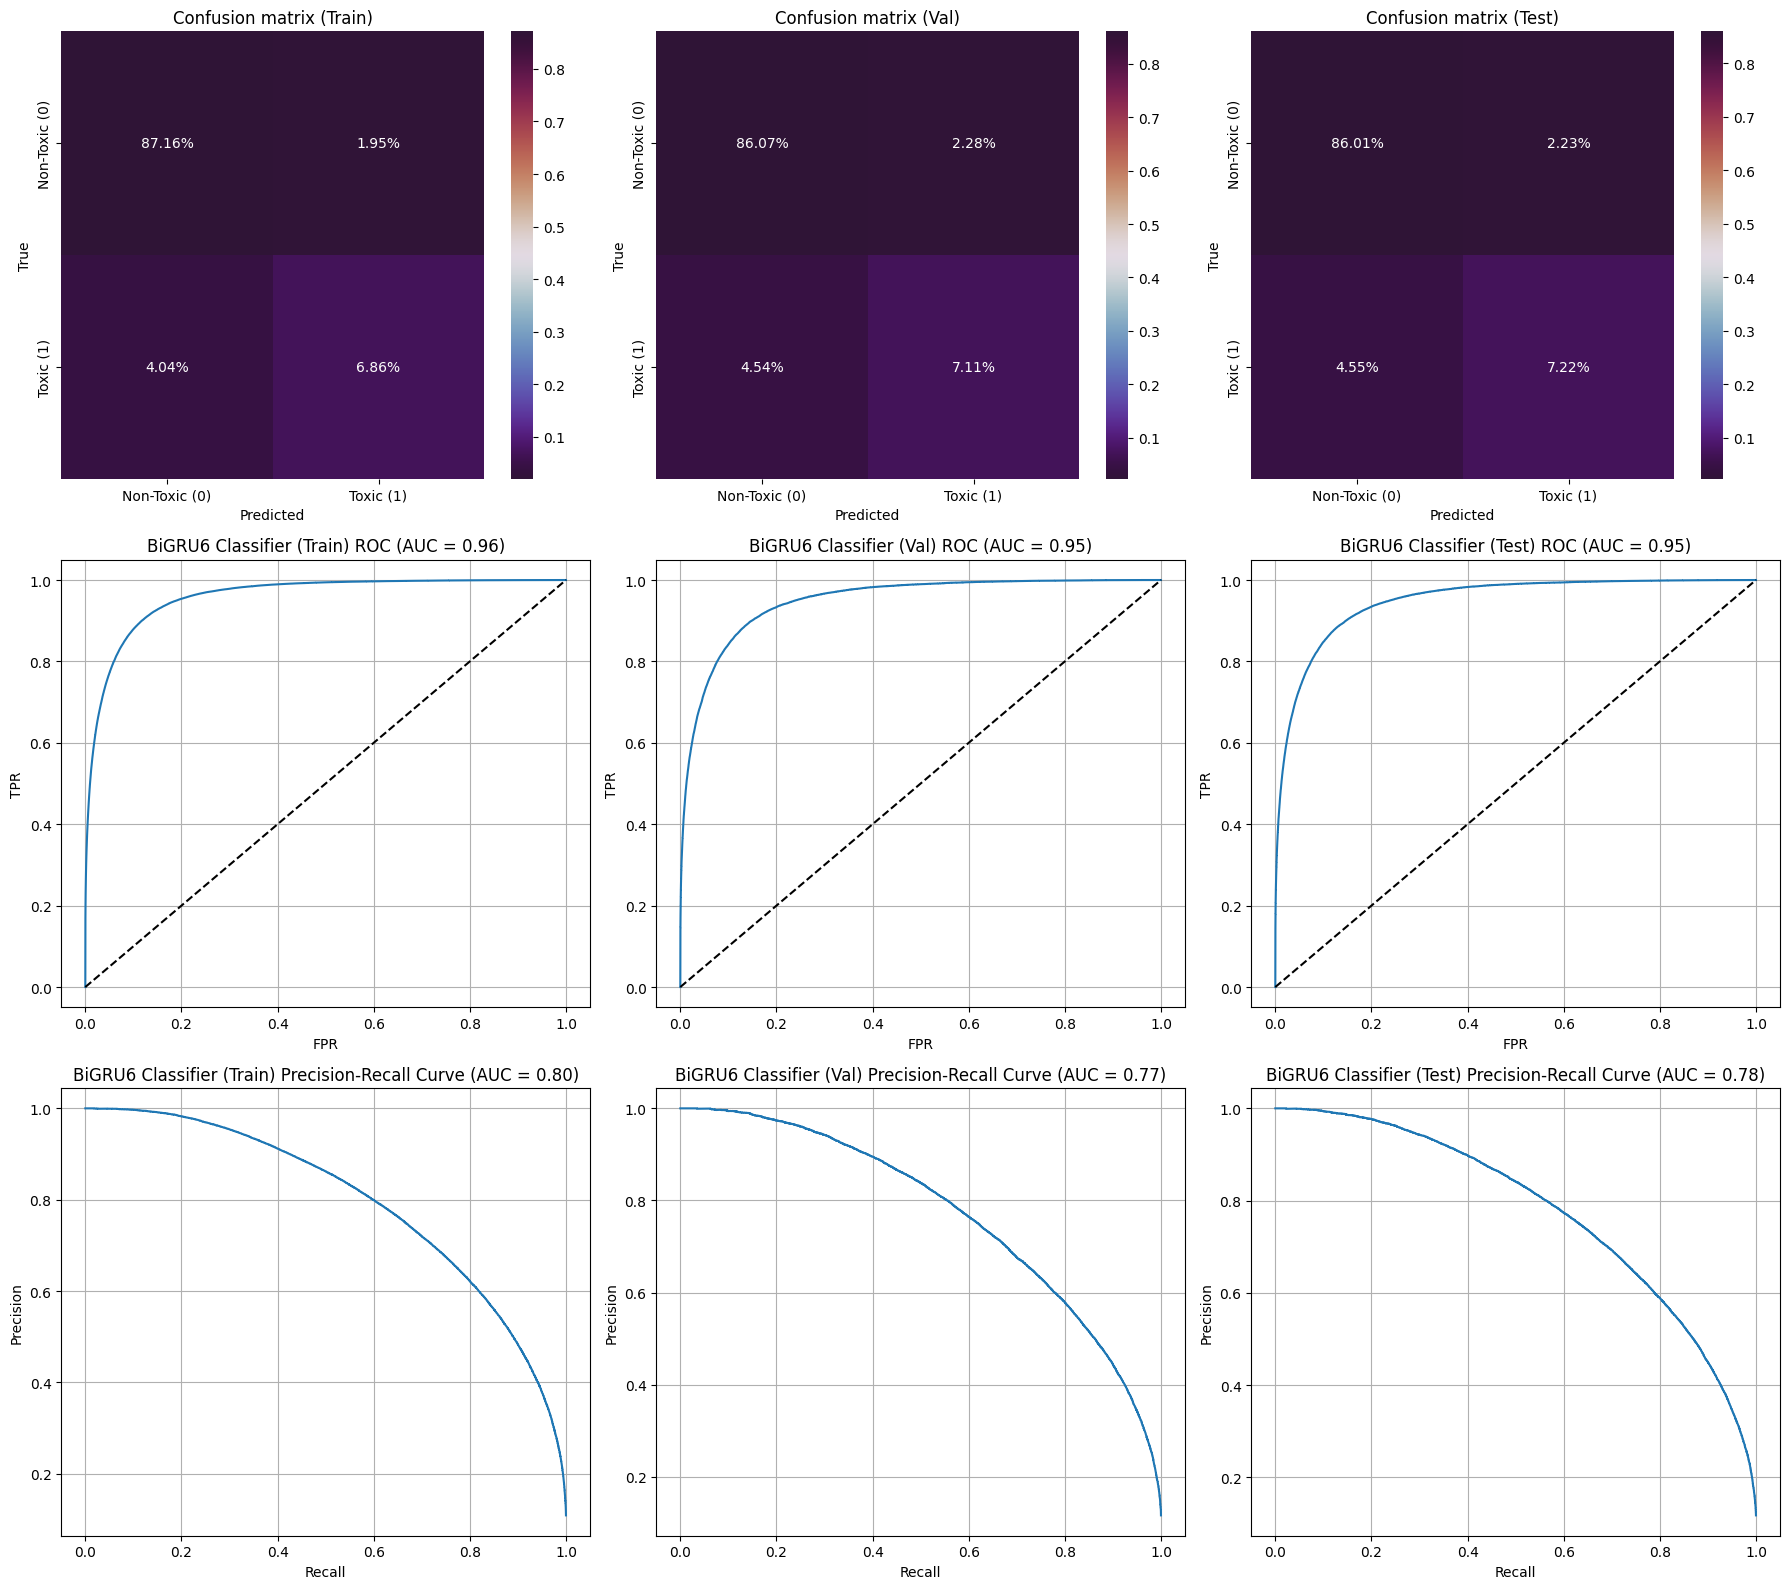

In [40]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiGRU6 Classifier"
)

In [41]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3900
Лучший F1: 0.6892


0.39

In [42]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

94006

## Обучение моделей LSTM

### LSTM Base

**LSTM 1 Layer**

In [52]:
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)
test_dataset = ToxicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [58]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=40734,
        embedding_size=512,
        hidden_size=256,
        num_classes=2,
        num_layers=1,
        dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)
        #nn.init.constant_(self.linear.bias, -1.5)  # помогает стартовать не с 0.5 вероятности

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        last_hidden = hidden[-1]
        last_hidden = self.dropout(last_hidden)
        return self.linear(last_hidden).squeeze(1)

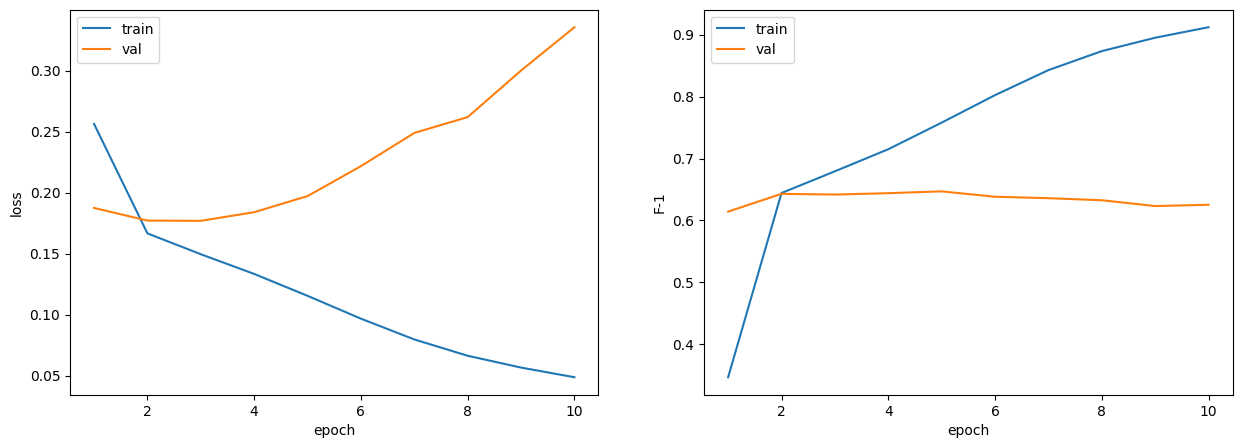

Best Validation Loss: 0.1768 (model saved to LSTM1_best.pth)


In [60]:
model = LSTMClassifier().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='LSTM1_best.pth'
)

In [61]:
model.load_state_dict(torch.load('LSTM1_best.pth'))

<All keys matched successfully>

LSTM 1 Classifier

Precision		Recall			F1

Train: 0.83		Train: 0.65		Train: 0.73
Val: 0.76		Val: 0.58		Val: 0.66
Test: 0.76		Test: 0.59		Test: 0.66


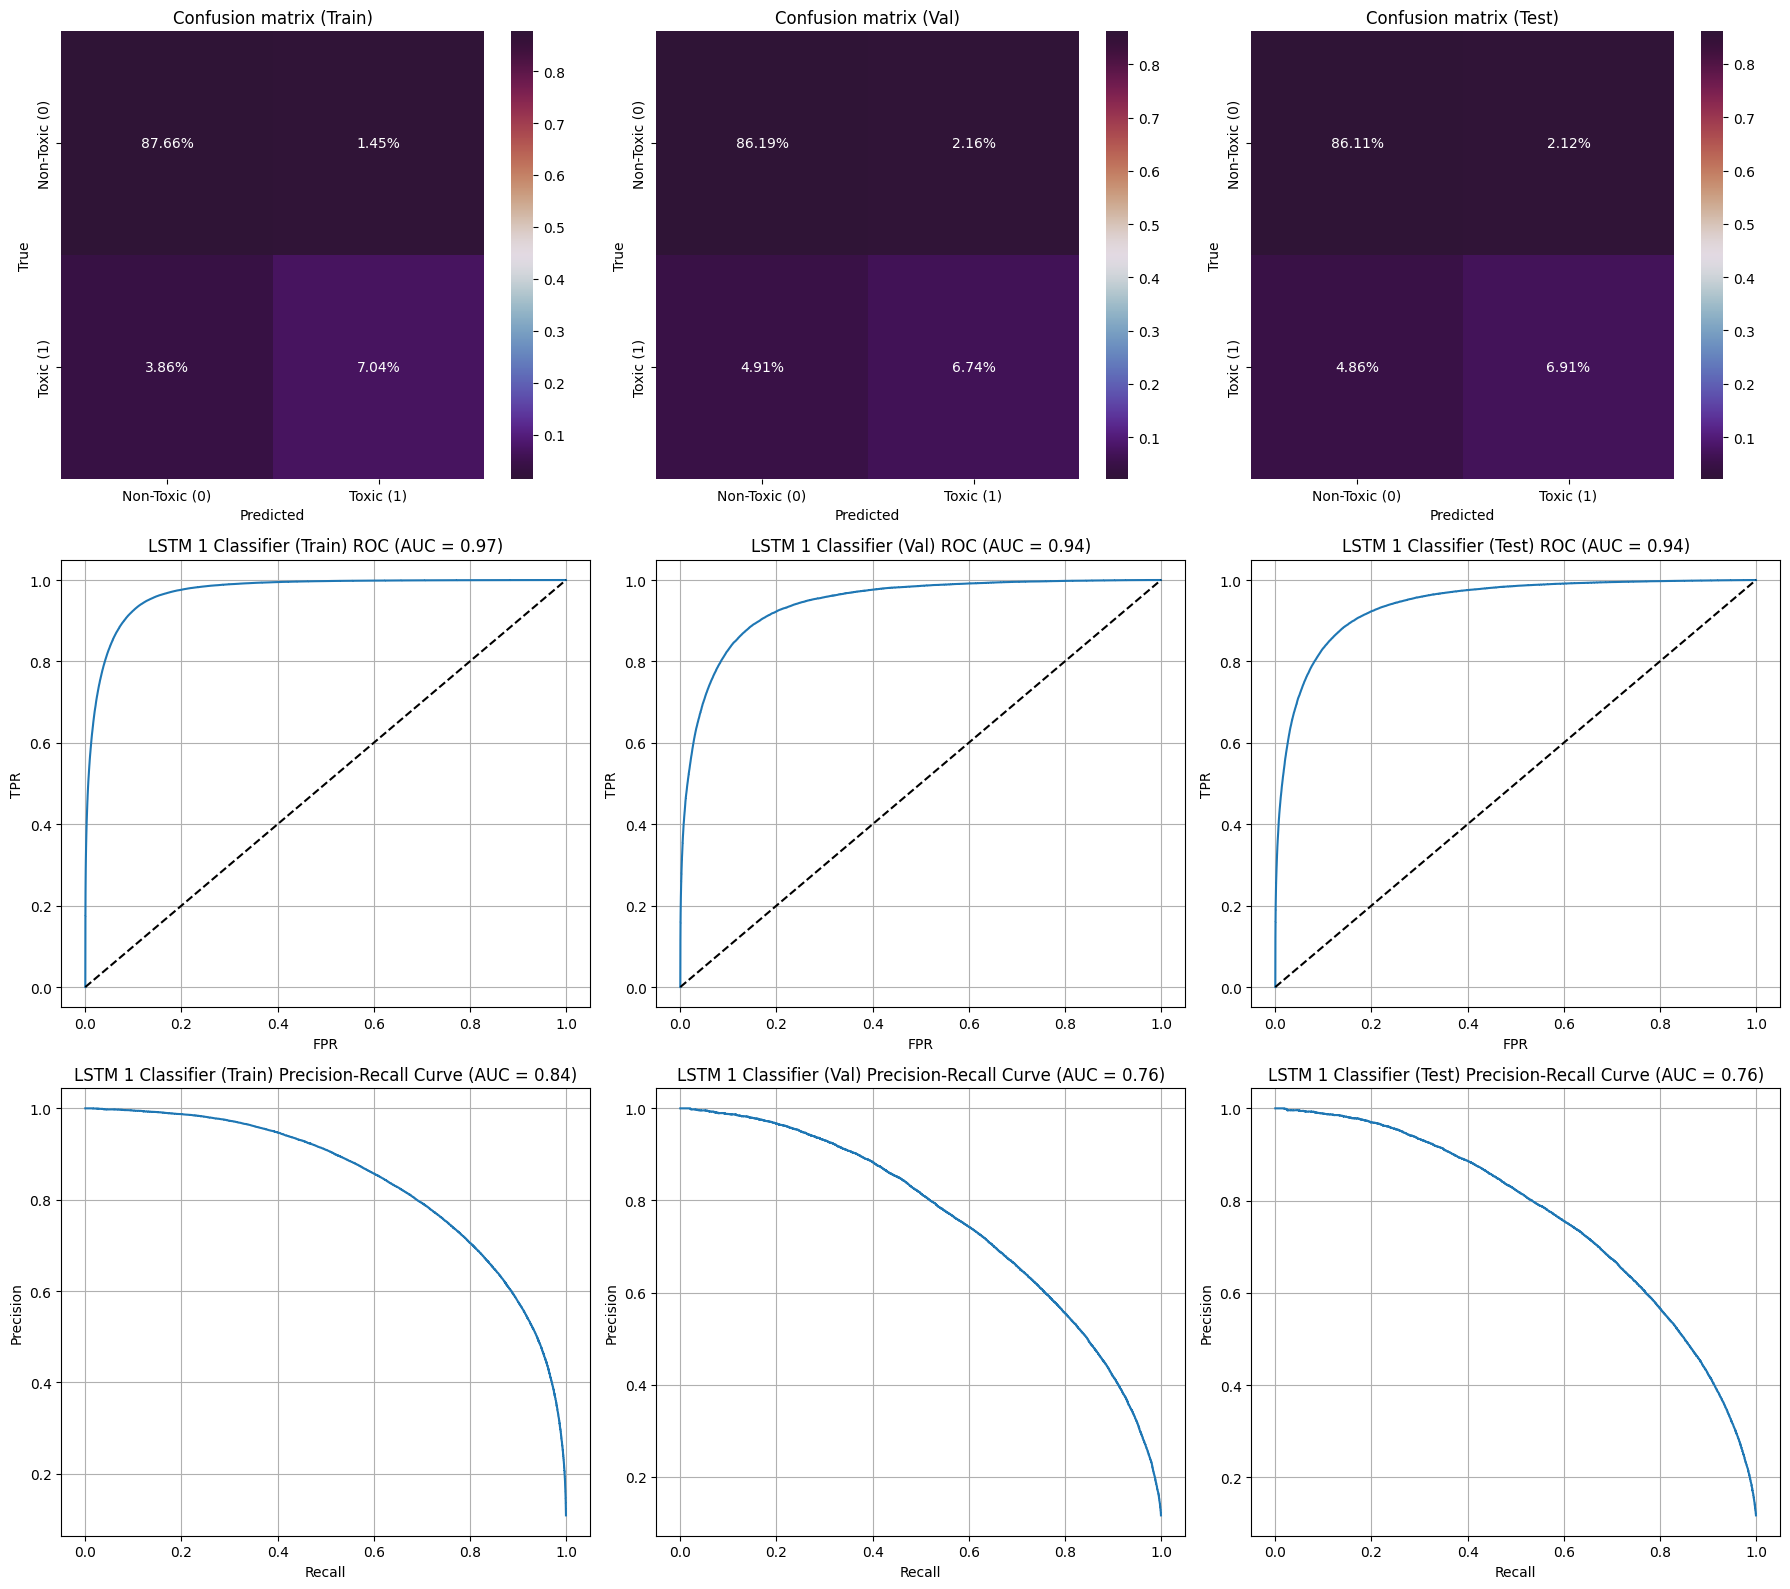

In [62]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="LSTM 1 Classifier"
)

In [63]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3800
Лучший F1: 0.6787


0.38

In [64]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

287160

**LSTM 2 Layers**

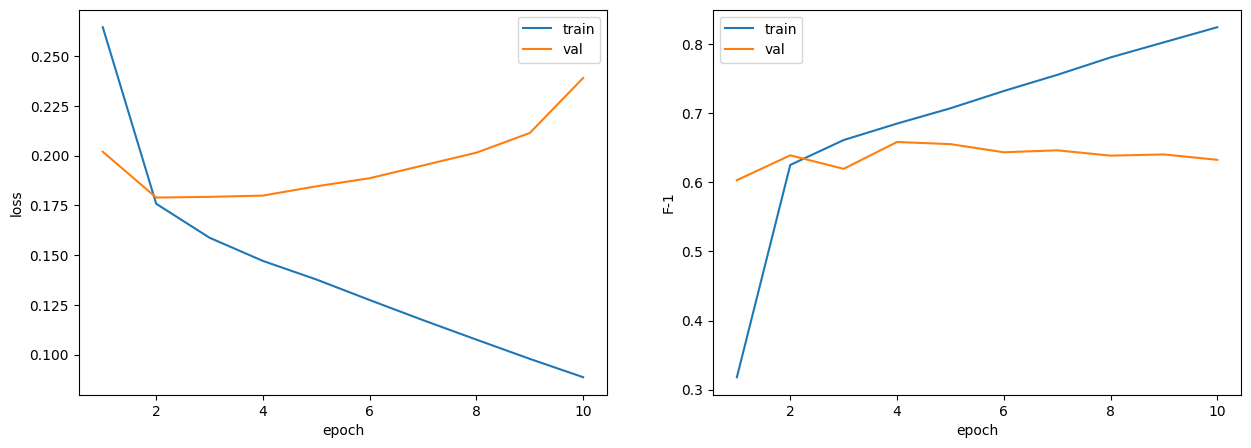

Best Validation Loss: 0.1789 (model saved to LSTM2_best.pth)


In [66]:
model = LSTMClassifier(num_layers=2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='LSTM2_best.pth'
)

In [67]:
model.load_state_dict(torch.load('LSTM2_best.pth'))

<All keys matched successfully>

LSTM 2 Classifier

Precision		Recall			F1

Train: 0.79		Train: 0.60		Train: 0.68
Val: 0.76		Val: 0.57		Val: 0.65
Test: 0.76		Test: 0.58		Test: 0.66


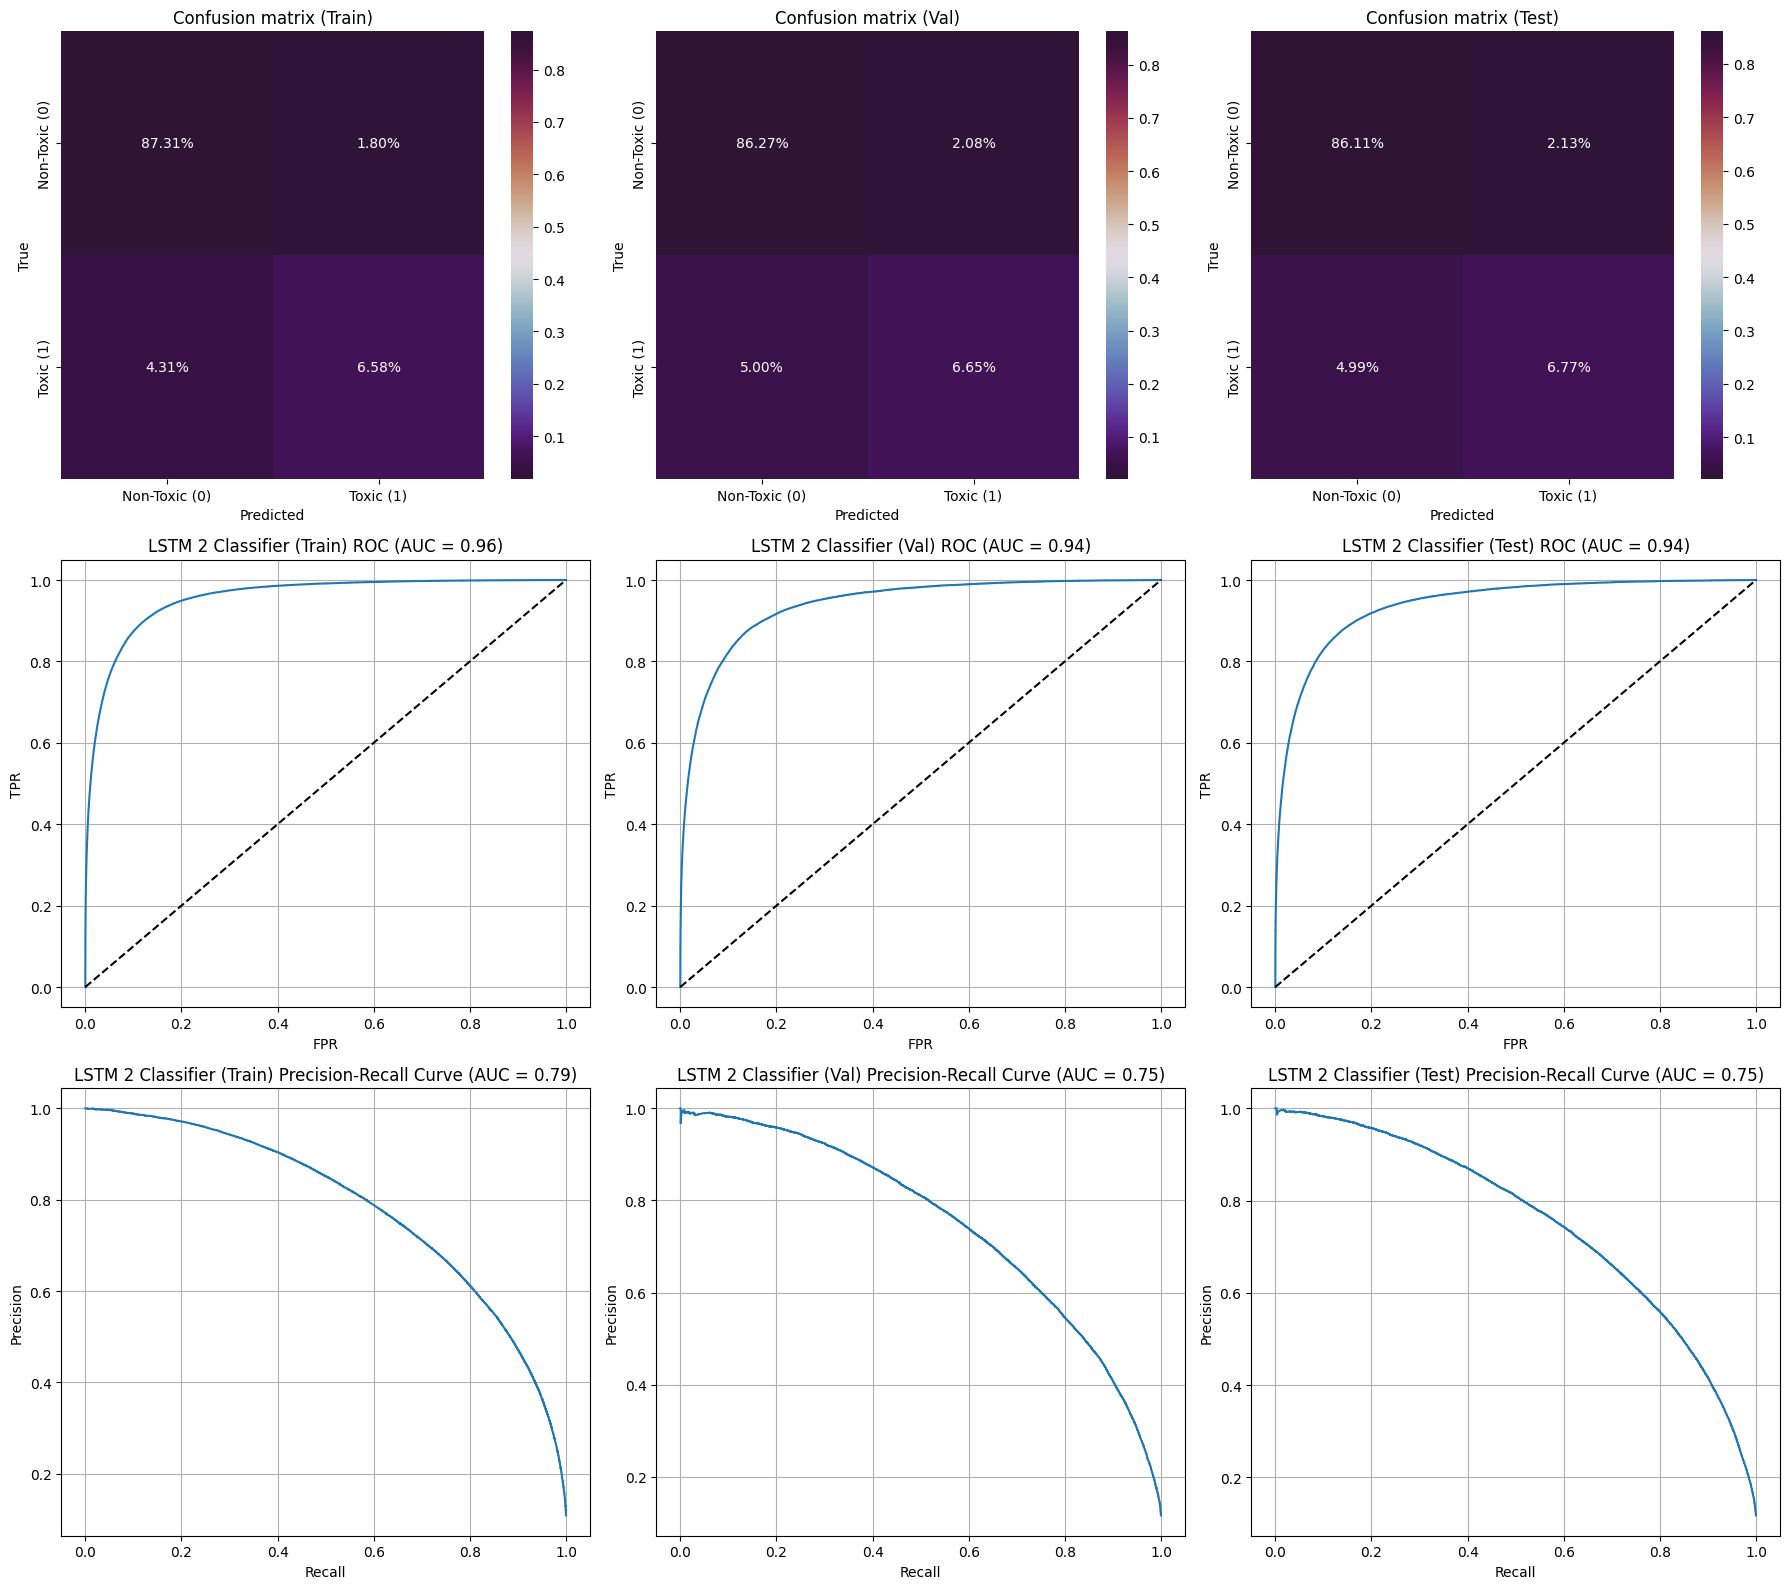

In [68]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="LSTM 2 Classifier"
)

In [69]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3500
Лучший F1: 0.6758


0.35000000000000003

In [70]:
del model
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

121593

### BiLSTM

In [71]:
class BiLSTMClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=40734,
        embedding_size=512,
        hidden_size=396,
        num_classes=1,  # 1 для бинарной классификации
        num_layers=1,
        pad_token=1,
        dropout=0.5,
        mode='last'  # ['last', 'avgpool', 'maxpool', 'attention', 'concat']
    ):
        super(BiLSTMClassifier, self).__init__()

        self.mode = mode
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(
            num_embeddings, embedding_size, padding_idx=pad_token
        )

        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        self.dropout = nn.Dropout(dropout)

        if mode == 'concat':
            fc_input_dim = hidden_size * 6
        else:
            fc_input_dim = hidden_size * 2

        self.linear = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))  # [B, T, E]
        lstm_out, (hidden, _) = self.lstm(embedded)  # lstm_out: [B, T, 2H], hidden: [2L, B, H]

        if self.mode == 'last':
            rep = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]

        elif self.mode == 'avgpool':
            rep = torch.mean(lstm_out, dim=1)  # [B, 2H]

        elif self.mode == 'maxpool':
            rep = torch.max(lstm_out, dim=1)[0]  # [B, 2H]

        elif self.mode == 'attention':
            scores = torch.tanh(lstm_out)  # [B, T, 2H]
            attn_weights = torch.matmul(scores, torch.ones(scores.shape[2], 1, device=x.device))  # [B, T, 1]
            attn_weights = torch.softmax(attn_weights, dim=1)
            rep = torch.sum(attn_weights * lstm_out, dim=1)  # [B, 2H]

        elif self.mode == 'concat':
            last = torch.cat((hidden[-2], hidden[-1]), dim=1)
            avg = torch.mean(lstm_out, dim=1)
            maxp = torch.max(lstm_out, dim=1)[0]
            rep = torch.cat([last, avg, maxp], dim=1)  # [B, 6H]

        else:
            raise ValueError(f"Unknown mode: {self.mode}")

        out = self.linear(self.dropout(rep))  # [B, 1]
        return out.squeeze(1) 

**BiLSTM Base**

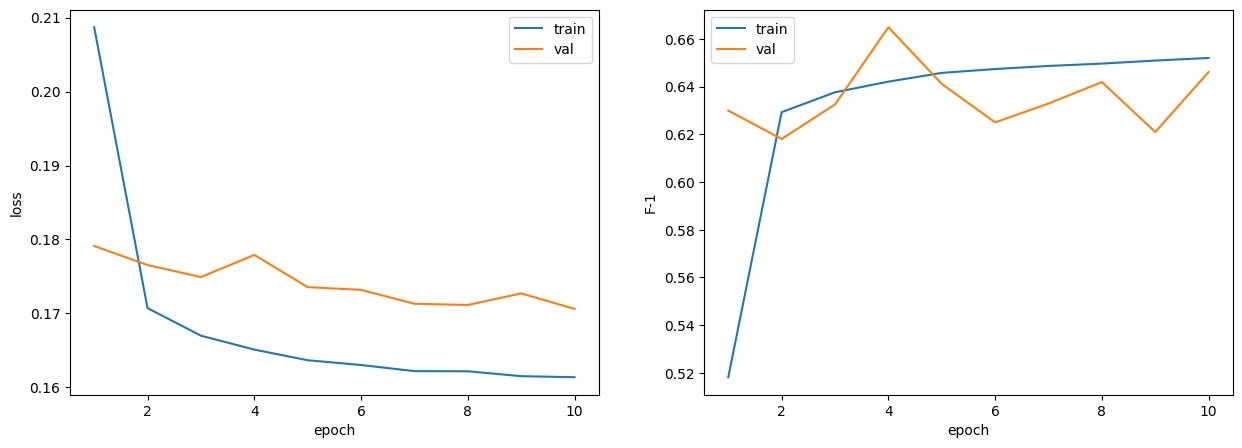

Best Validation Loss: 0.1706 (model saved to BiLSTM_best.pth)


In [89]:
model = BiLSTMClassifier(num_layers=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiLSTM_best.pth'
)

In [90]:
model.load_state_dict(torch.load('BiLSTM_best.pth'))

<All keys matched successfully>

BiLSTM Classifier

Precision		Recall			F1

Train: 0.80		Train: 0.59		Train: 0.68
Val: 0.78		Val: 0.57		Val: 0.66
Test: 0.79		Test: 0.57		Test: 0.66


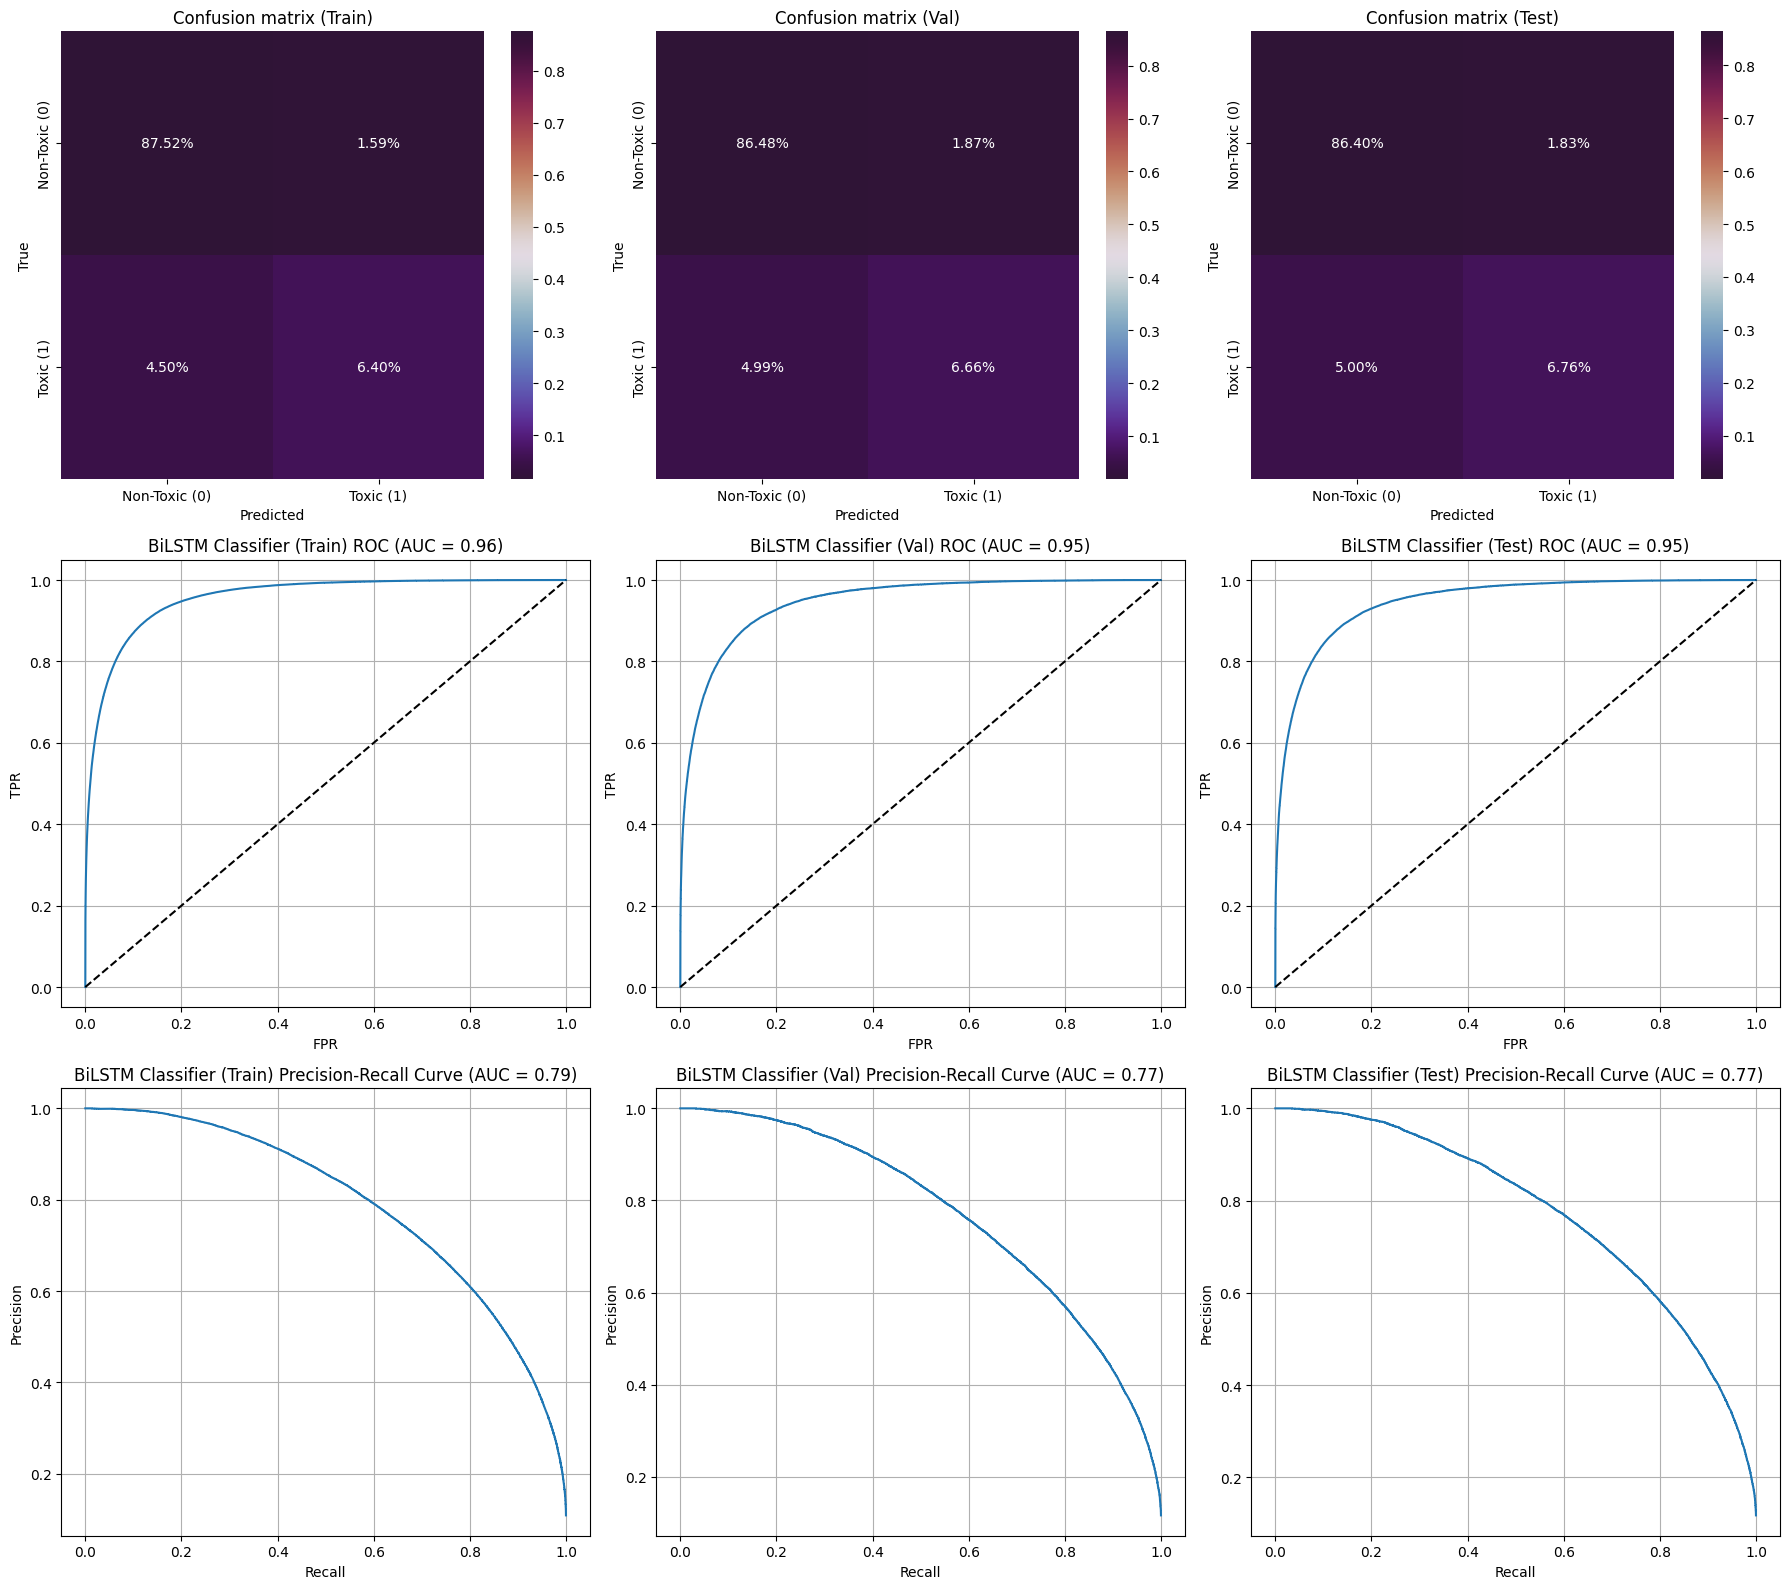

In [91]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiLSTM Classifier"
)

In [92]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3200
Лучший F1: 0.6866


0.32

In [93]:
del model
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()     
gc.collect()

102818

**Stacked BiLSTM**

In [94]:
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)
test_dataset = ToxicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

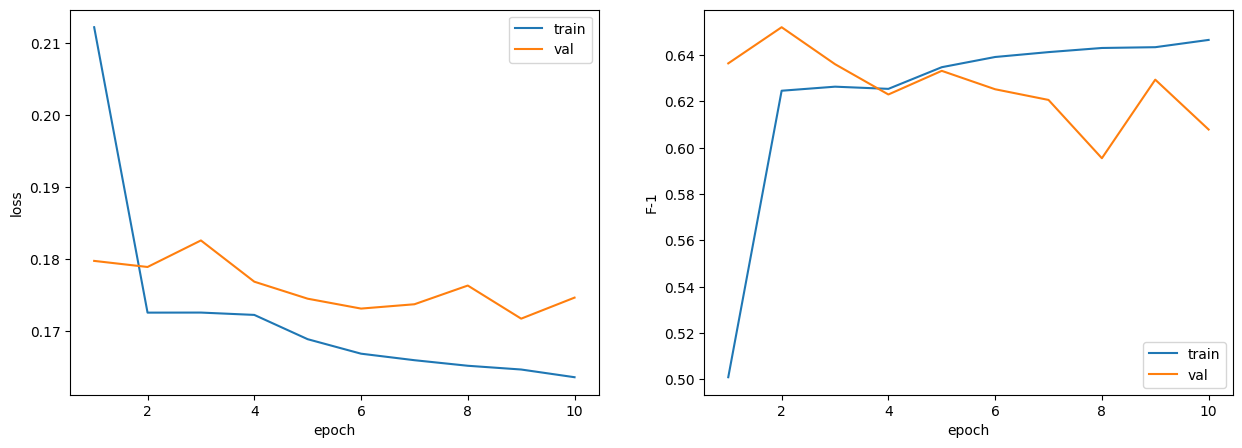

Best Validation Loss: 0.1718 (model saved to BiLSTM2_best.pth)


In [95]:
model = BiLSTMClassifier(num_layers=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiLSTM2_best.pth'
)

In [96]:
model.load_state_dict(torch.load('BiLSTM2_best.pth'))

<All keys matched successfully>

BiLSTM2 Classifier

Precision		Recall			F1

Train: 0.82		Train: 0.55		Train: 0.66
Val: 0.80		Val: 0.54		Val: 0.64
Test: 0.81		Test: 0.54		Test: 0.65


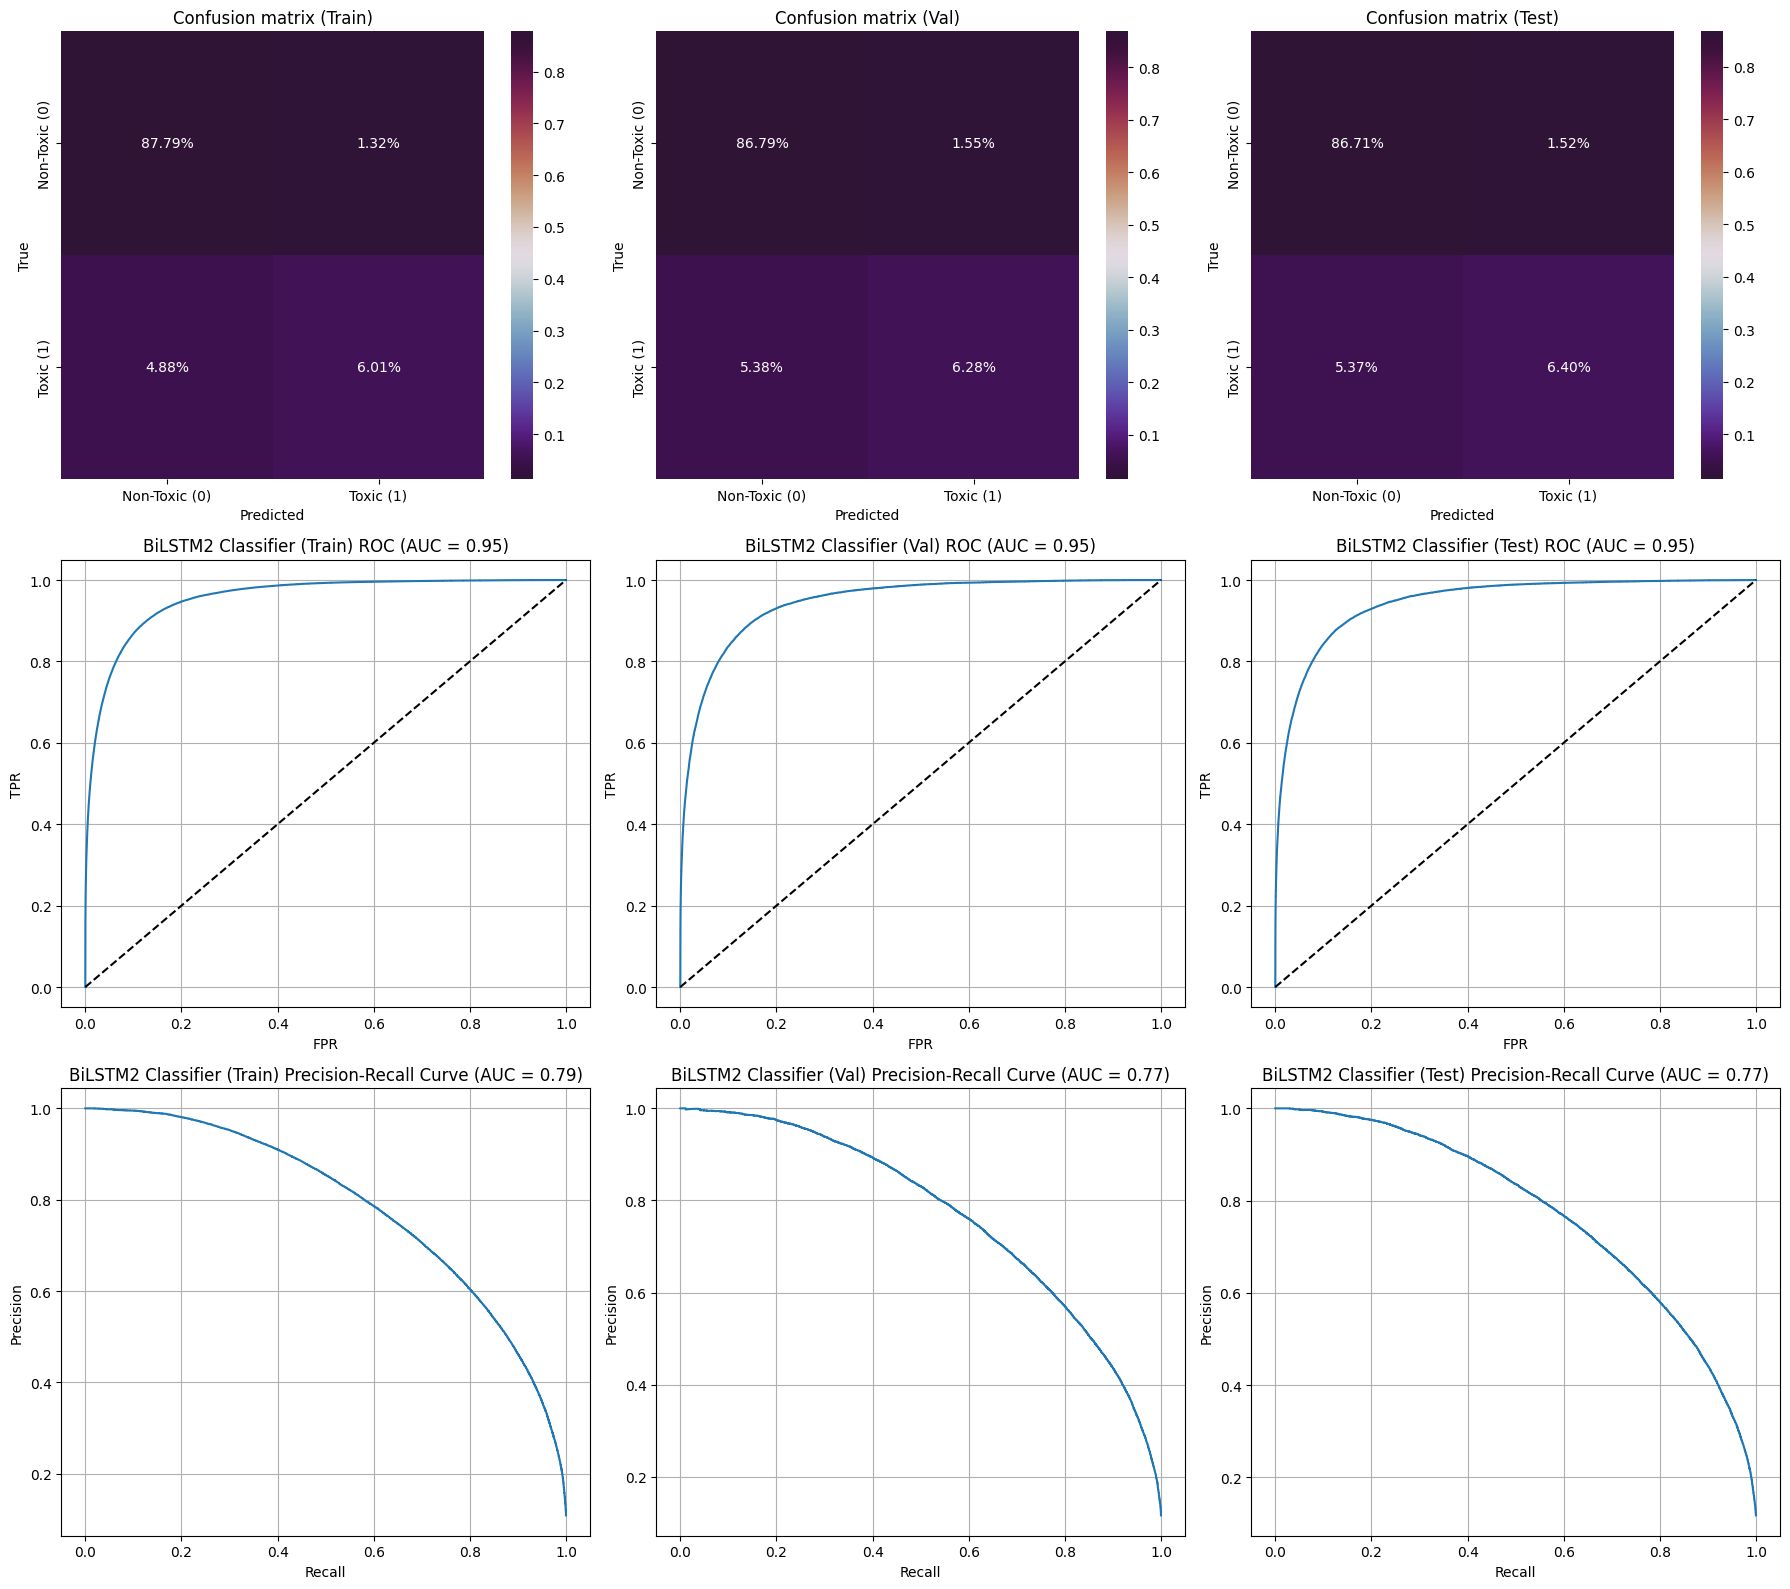

In [97]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiLSTM2 Classifier"
)

In [98]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3200
Лучший F1: 0.6869


0.32

In [99]:
del model
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()     
gc.collect()

102465

**AvgPool + BiLSTM**

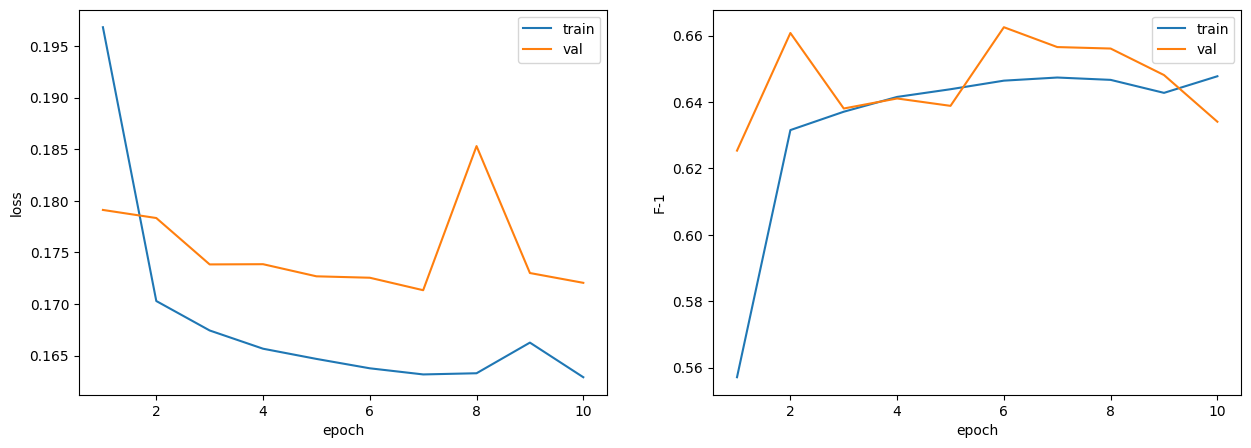

Best Validation Loss: 0.1713 (model saved to BiLSTM3_best.pth)


In [100]:
model = BiLSTMClassifier(num_layers=3, mode='avgpool').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiLSTM3_best.pth'
)

In [101]:
model.load_state_dict(torch.load('BiLSTM3_best.pth'))

<All keys matched successfully>

BiLSTM3 Classifier

Precision		Recall			F1

Train: 0.78		Train: 0.61		Train: 0.69
Val: 0.76		Val: 0.60		Val: 0.67
Test: 0.76		Test: 0.61		Test: 0.68


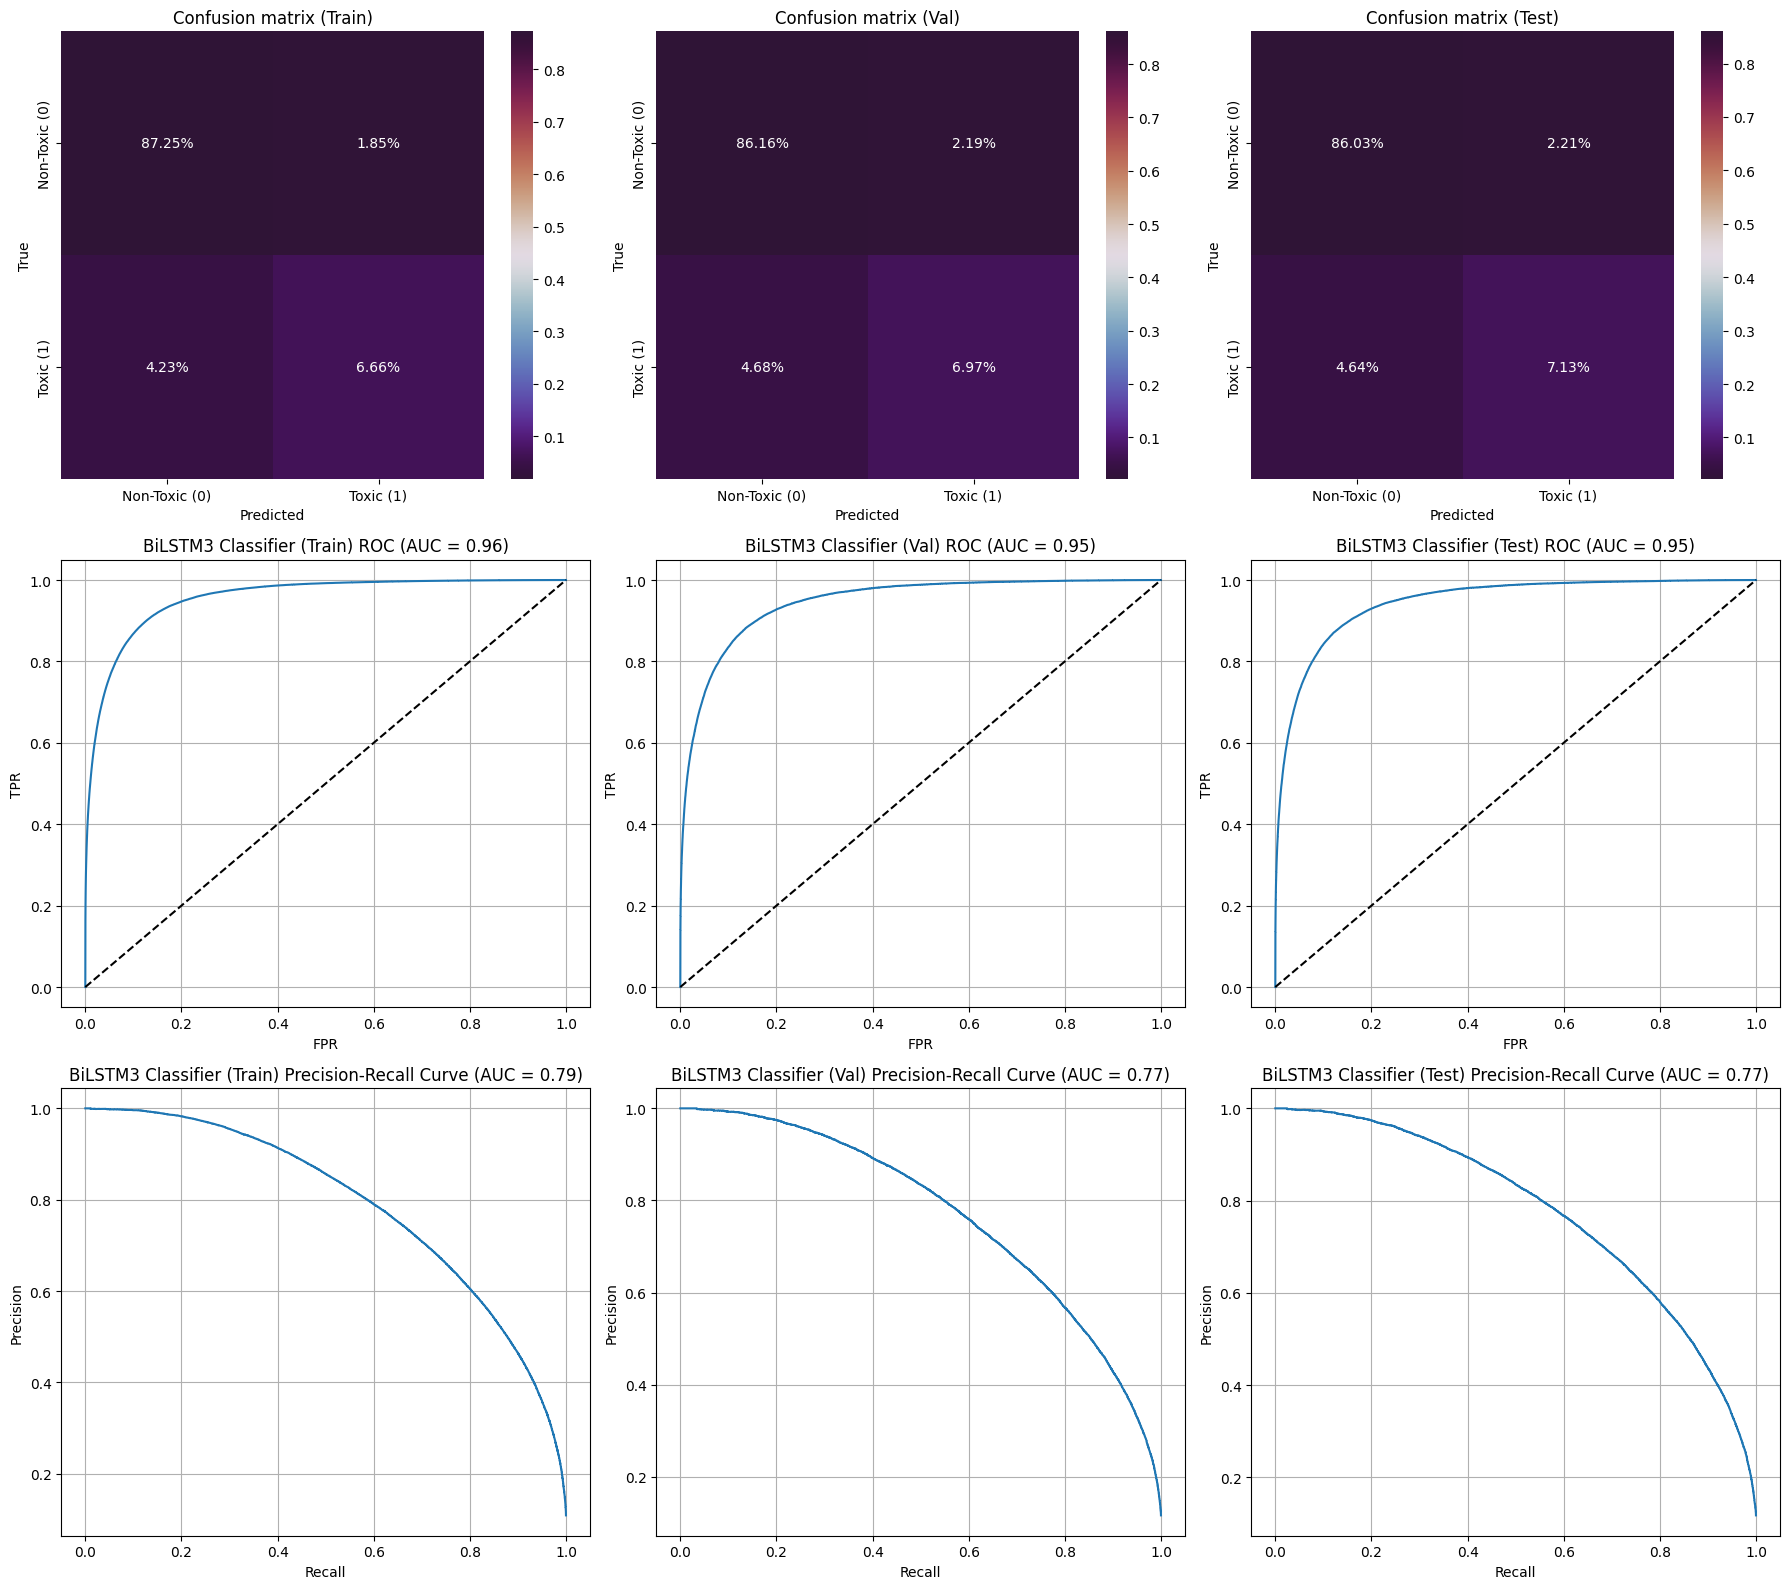

In [102]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiLSTM3 Classifier"
)

In [103]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3600
Лучший F1: 0.6858


0.36000000000000004

In [104]:
del model
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()     
gc.collect()

101297

**MaxPool + BiLSTM**

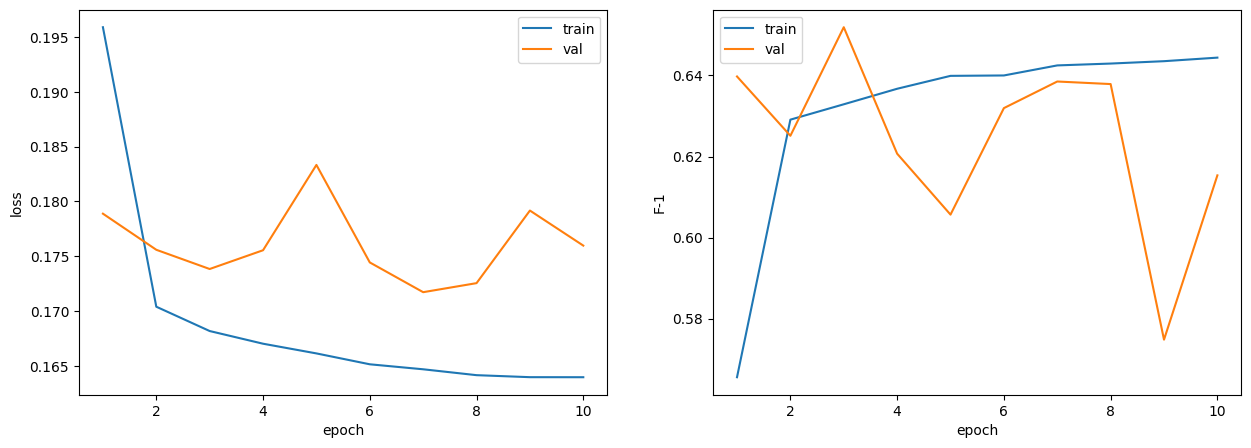

Best Validation Loss: 0.1717 (model saved to BiLSTM4_best.pth)


In [105]:
model = BiLSTMClassifier(num_layers=3, mode='maxpool').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiLSTM4_best.pth'
)

In [106]:
model.load_state_dict(torch.load('BiLSTM4_best.pth'))

<All keys matched successfully>

BiLSTM4 Classifier

Precision		Recall			F1

Train: 0.80		Train: 0.57		Train: 0.67
Val: 0.79		Val: 0.55		Val: 0.65
Test: 0.80		Test: 0.56		Test: 0.66


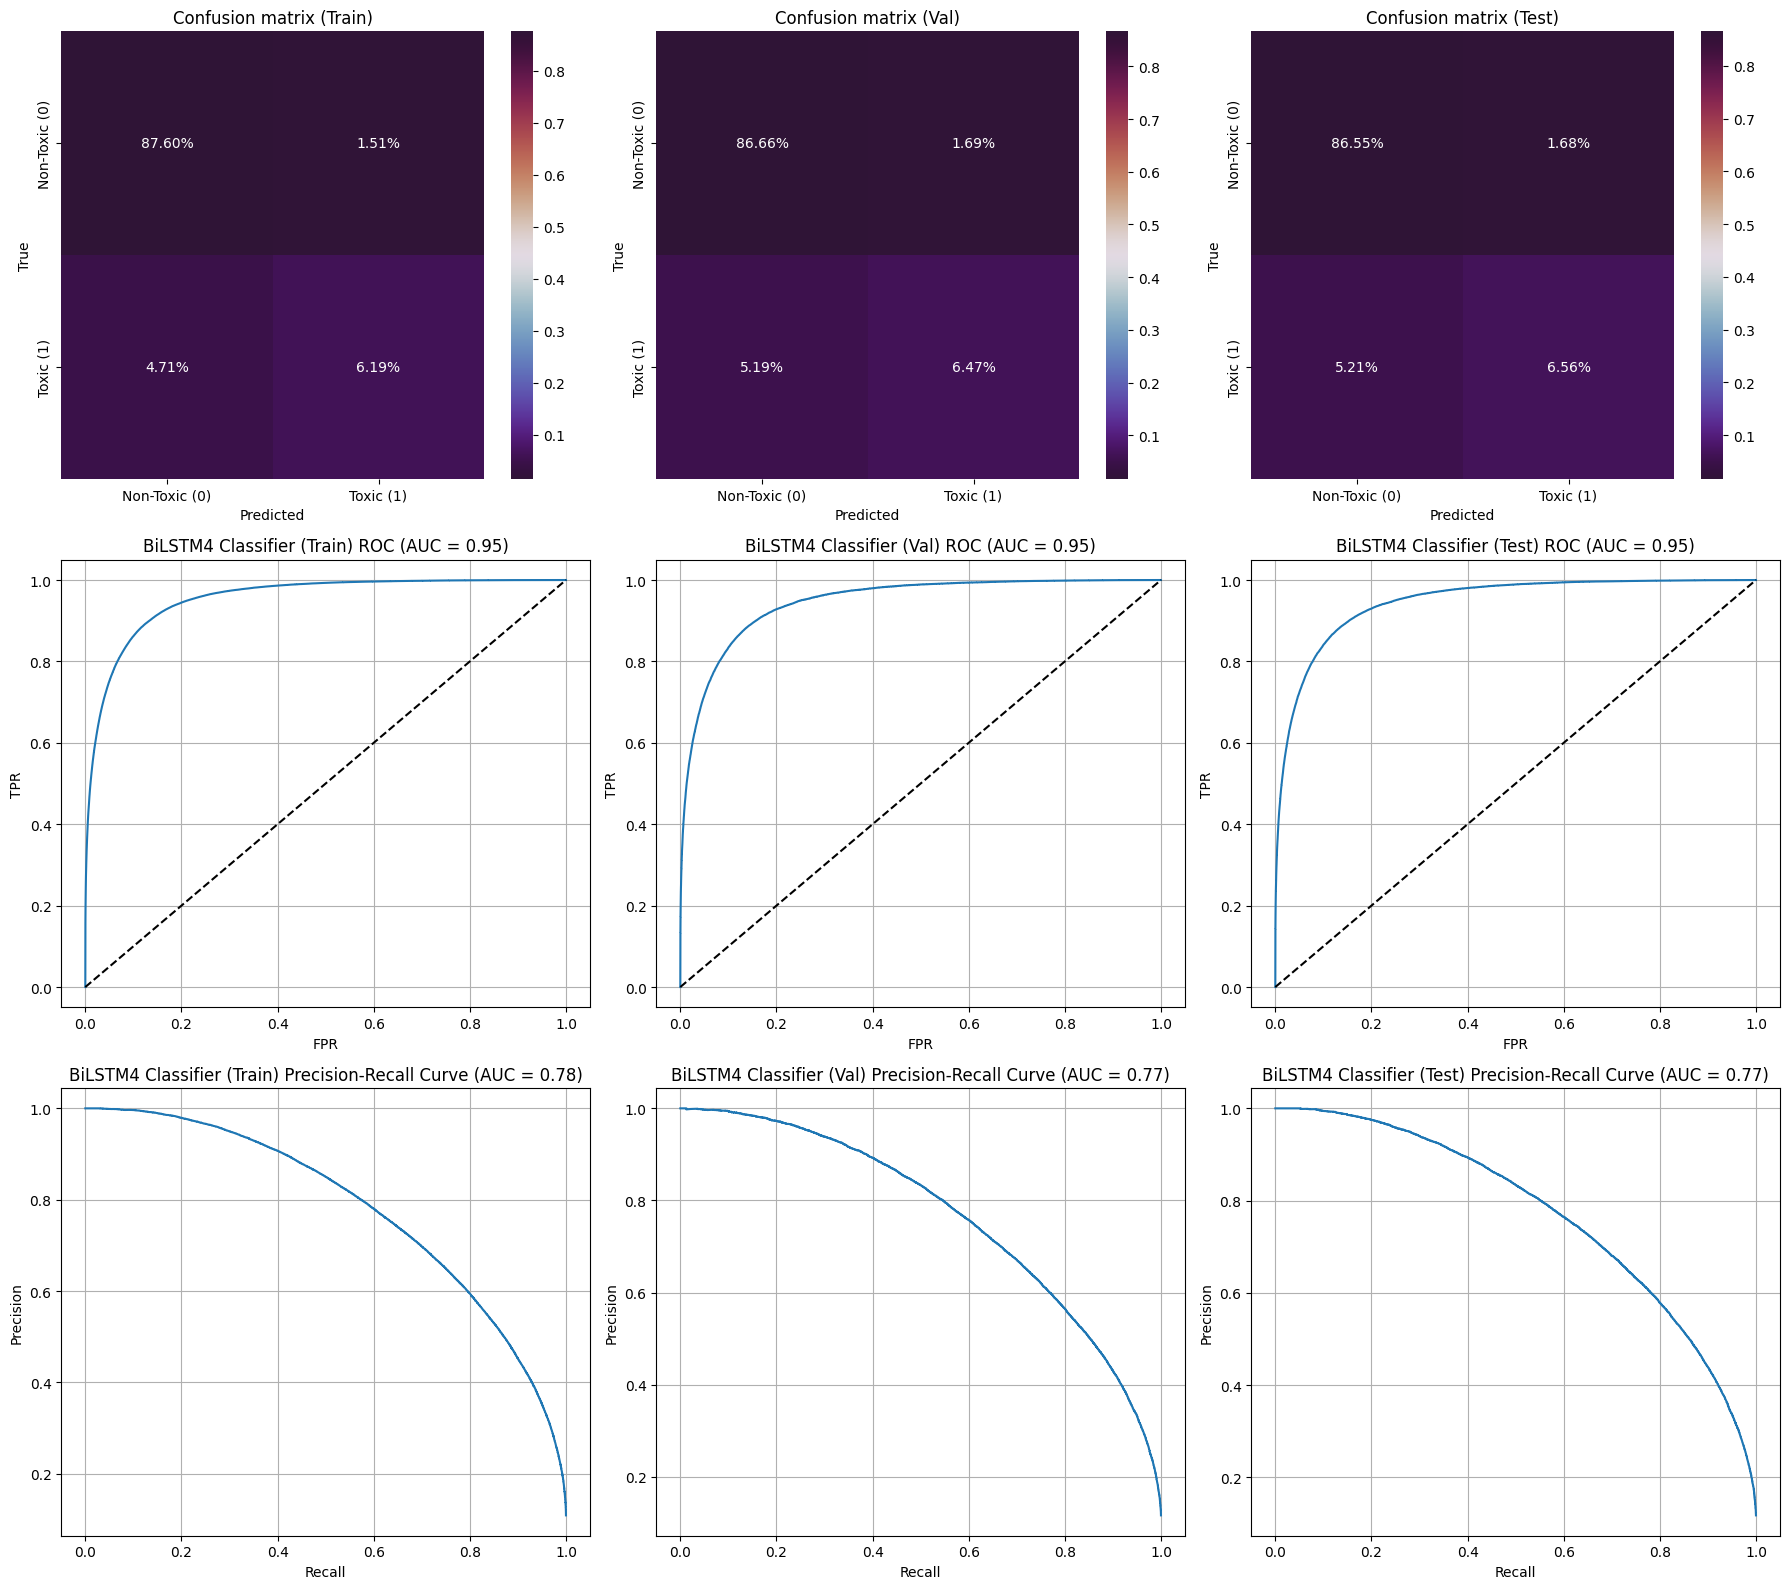

In [107]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiLSTM4 Classifier"
)

In [108]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3300
Лучший F1: 0.6850


0.33

In [109]:
del model
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()     
gc.collect()

93549

**Attention + BiLSTM**

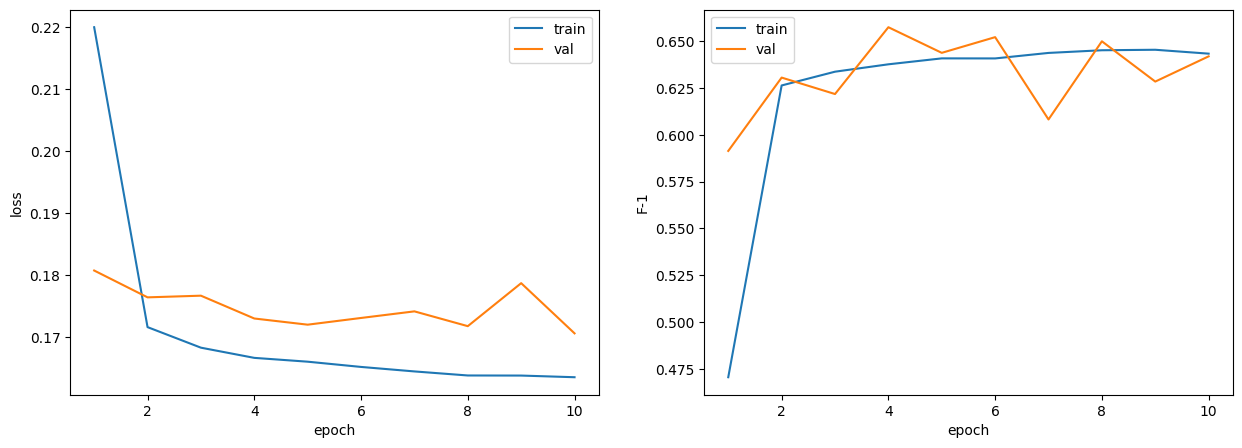

Best Validation Loss: 0.1706 (model saved to BiLSTM5_best.pth)


In [111]:
model = BiLSTMClassifier(num_layers=3, mode='attention', hidden_size=256).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiLSTM5_best.pth'
)

In [112]:
model.load_state_dict(torch.load('BiLSTM5_best.pth'))

<All keys matched successfully>

BiLSTM5 Classifier

Precision		Recall			F1

Train: 0.80		Train: 0.58		Train: 0.68
Val: 0.78		Val: 0.57		Val: 0.66
Test: 0.79		Test: 0.57		Test: 0.66


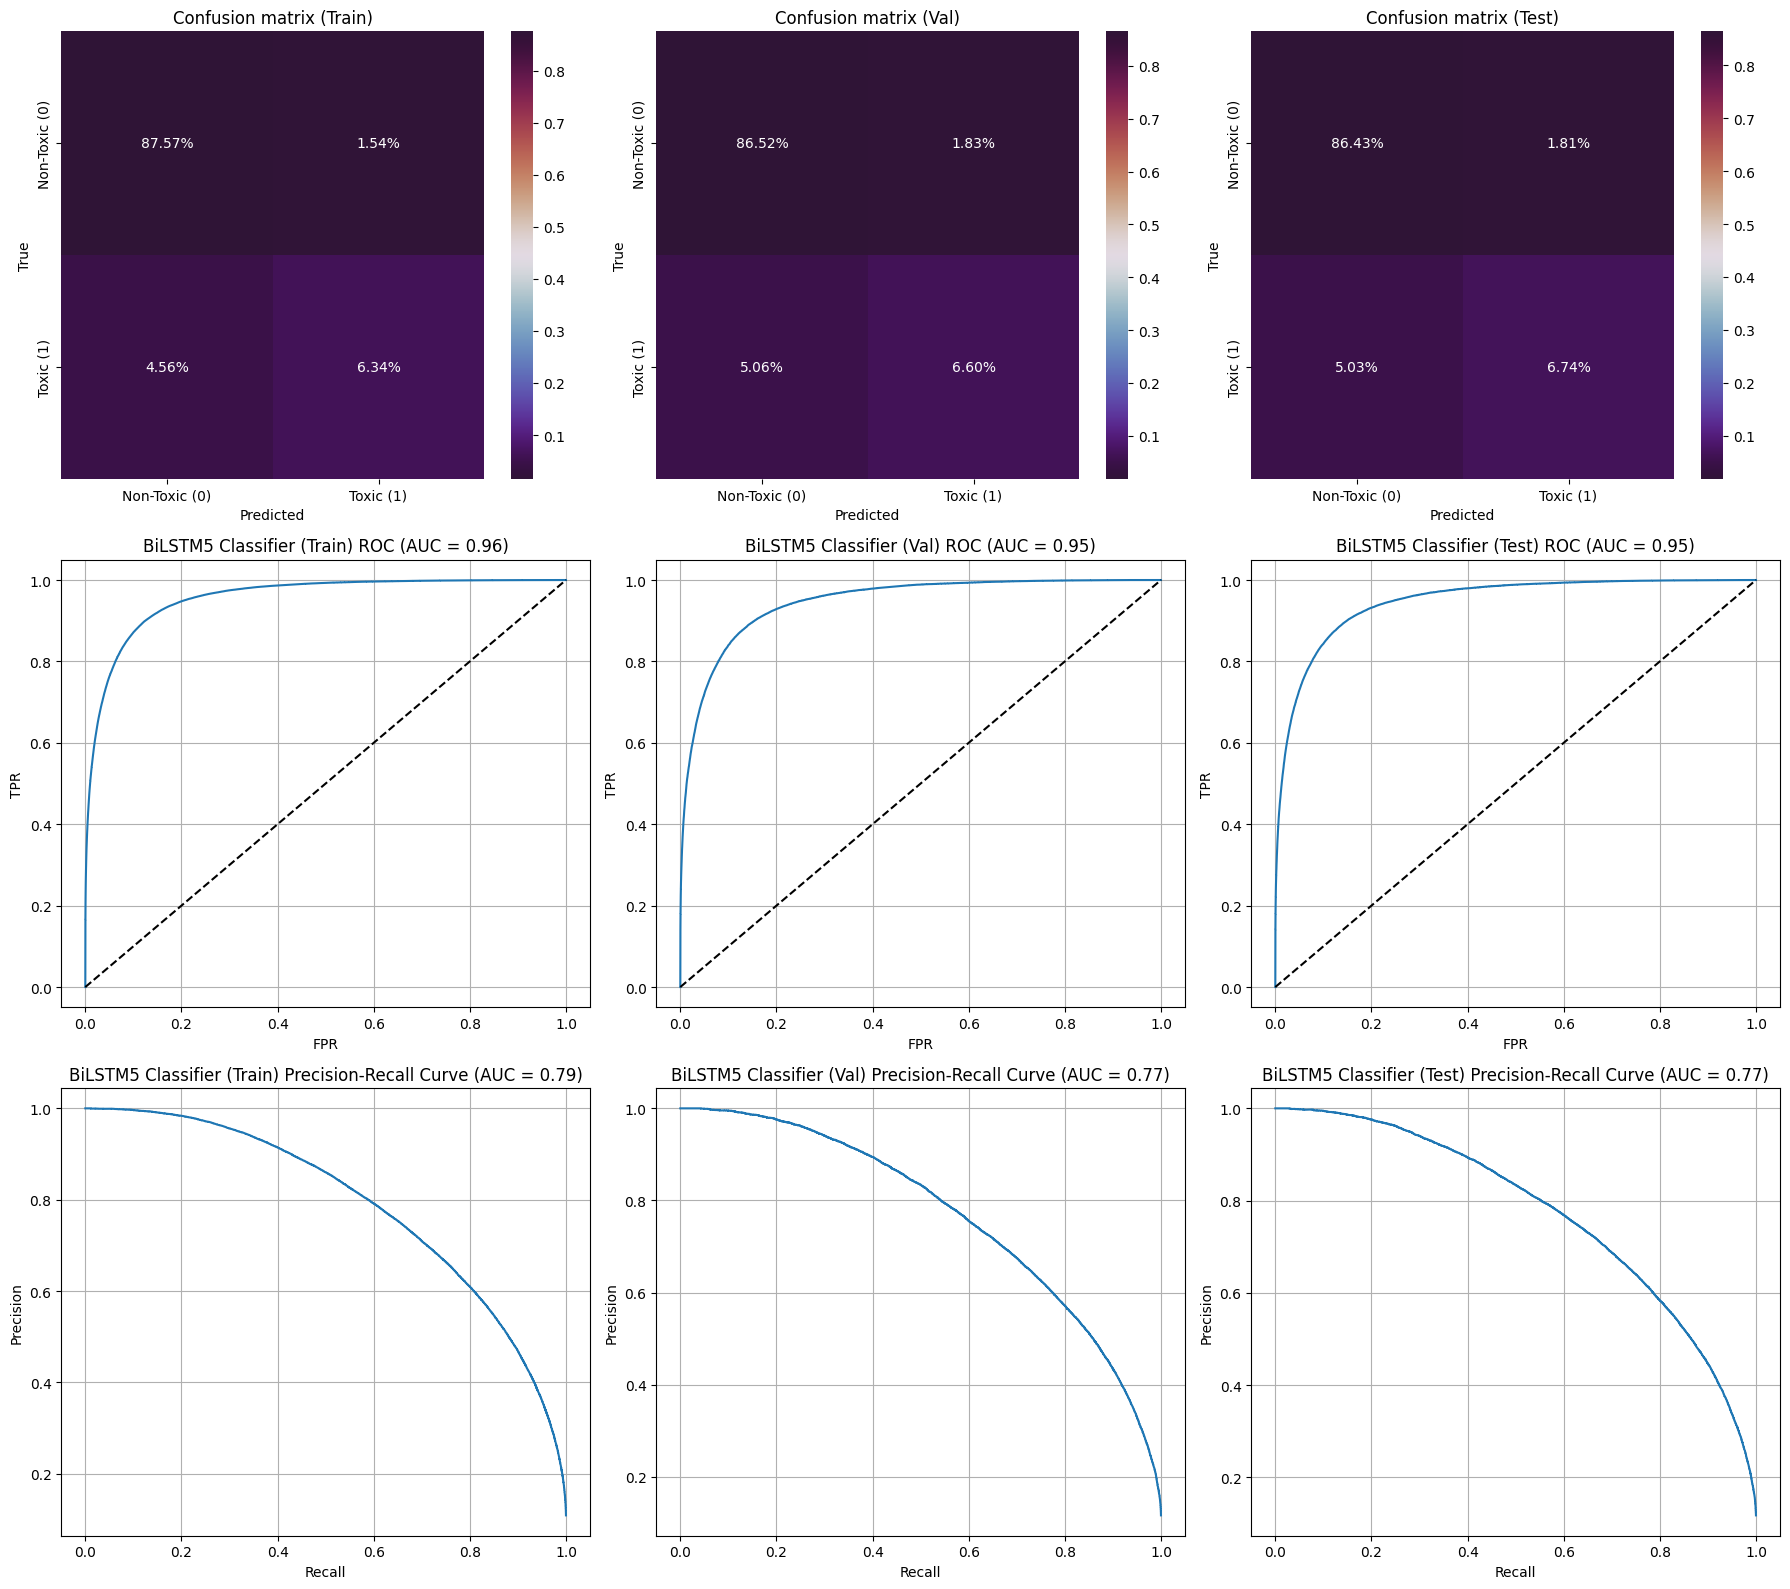

In [113]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiLSTM5 Classifier"
)

In [114]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3500
Лучший F1: 0.6873


0.35000000000000003

In [115]:
del model
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()     
gc.collect()

109861

**Last + AvgPool + MaxPool + BiLSTM**

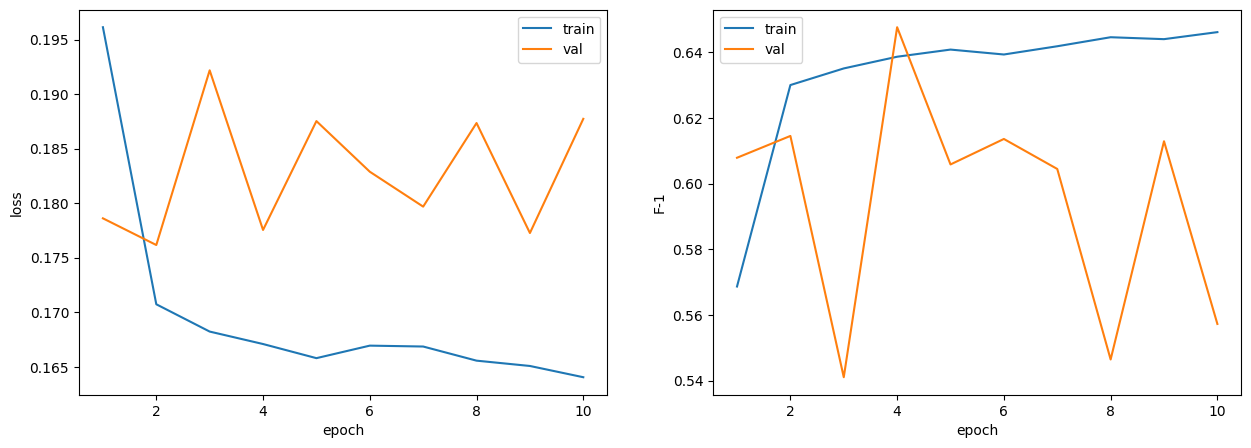

Best Validation Loss: 0.1762 (model saved to BiLSTM6_best.pth)


In [116]:
model = BiLSTMClassifier(num_layers=3, mode='concat').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='BiLSTM6_best.pth'
)

In [117]:
model.load_state_dict(torch.load('BiLSTM6_best.pth'))

<All keys matched successfully>

In [ ]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.5).astype(int)
y_pred_val = (y_pred_proba_val > 0.5).astype(int)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="BiLSTM6 Classifier"
)

In [ ]:
find_best_t(y_pred_proba_val, y_val)

In [ ]:
del model
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()     
gc.collect()